# Projet 6: Classifiez automatiquement des biens de consommation

Etudier la faisabilité d'un moteur de **classification des articles en différentes catégories** basé sur une **image** et une **description** pour l'automatisation de l'attribution de la catégorie de l'article.

Les **descriptions des produits et des images** doivent êtres **prétraitées**, une **réduction de dimension** effectuée puis un **clustering**.

Les résultats de la réduction de dimension et du clustering doivent être présentés sous forme de **graphiques en 2 dimensions** et confirmés par un **calcul de similarité entre les catégories réelles et les clusters**. Les résultats illustreront le fait que les caractéristiques extraites permettent de regrouper des produits de même catégorie.

Pour les **features texte**:
- 2 approches de type "bag_of-word": comptage simple de mots et Tf_idf
- 1 approche de type word/sentence embedding classique avec Word2Vec (ou Glove ou FastText)
- 1 approche de type word/sentence embedding avec BERT
- 1 approche de type word/sentence embedding avec USE (Universal Sentence Encoder)

Pour les **features image**:
- un algorithme de type SIFT / ORB / SURF
- un algorithme de type CNN Transfer Learning

## Table des matières: <a class="anchor" id="0"></a>

1. [Import des librairies et configurations générales](#library)
2. [Chargement et connaissance des données](#load)
3. [Nettoyage des données textuelles](#txt)
4. [Extraction de l'information du texte](#extract)
    1. [Approches de type bag of word](#bag)
        1. [Comptage simple de mots (Countvectorizer)](#cpte)
        2. [Tf_idf](#Tf_idf)
    2. [Approches de type word/sentence embedding classique](#wse)
        1. [Word2Vec](#w2v)
    3. [Approches de type word/sentence embedding avec BERT](#bert)
        1. [BERT HuggingFace](#bert_hugging)
        1. [BERT hub Tensorflow](#bert_tensor)
    4. [Approches de type word/sentence embedding avec USE](#use)

## Import des librairies et configurations générales <a class="anchor" id="library"></a>

In [1]:
# Pour vérifier si la convention PEP8 est respectée
# %load_ext pycodestyle_magic
# %pycodestyle_on

In [ ]:
import logging
logging.disable(logging.WARNING)

In [2]:
# builtin
import os
import sys
import time
import random

In [3]:
# data
import numpy as np
import pandas as pd
# from pandarallel import pandarallel
# pandarallel.initialize(progress_bar=True, nb_workers=6)

# Configuration Pandas
pd.set_option('display.max_colwidth', None)

In [4]:
# viz
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.collections import LineCollection
import seaborn as sns
from wordcloud import WordCloud

# Configuration générale des graphiques
parameters = {'axes.labelsize': 13,
              'axes.titlesize': 16,
              'axes.titleweight': 'bold'}
plt.rcParams.update(parameters)

C:\Users\milie\anaconda3\envs\projet6\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import manifold
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score

In [6]:
# Natural Language Processing
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('words')
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.stem import WordNetLemmatizer, PorterStemmer
import collections

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [7]:
# Word2Vec
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from gensim.models import Word2Vec
import gensim

In [8]:
# BERT
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert Huggingface
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

# Bert Tensorflow Hub
import tensorflow_hub as hub
import tensorflow_text 

C:\Users\milie\anaconda3\envs\projet6\lib\site-packages\transformers\generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(


In [157]:
# USE
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

import tensorflow_hub as hub

## Chargement et connaissance des données <a class="anchor" id="load"></a>

#### Import

In [9]:
# Import des données textuelles
data = pd.read_csv('data/flipkart_com-ecommerce_sample_1050.csv',
                   sep=',',
                   encoding='utf-8')

In [10]:
# Visualisation des 5 premières lignes du dataset
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdgthcts?pid=CRNEG7BKMFFYHQ8Z,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"[""Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do...""]",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you get the right amount of sunlight.,Specifications of Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) General Brand Elegance Designed For Door Type Eyelet Model Name Abstract Polyester Door Curtain Set Of 2 Model ID Duster25 Color Multicolor Dimensions Length 213 cm In the Box Number of Contents in Sales Package Pack of 2 Sales Package 2 Curtains Body & Design Material Polyester",No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""Elegance""}, {""key""=>""Designed For"", ""value""=>""Door""}, {""key""=>""Type"", ""value""=>""Eyelet""}, {""key""=>""Model Name"", ""value""=>""Abstract Polyester Door Curtain Set Of 2""}, {""key""=>""Model ID"", ""value""=>""Duster25""}, {""key""=>""Color"", ""value""=>""Multicolor""}, {""key""=>""Length"", ""value""=>""213 cm""}, {""key""=>""Number of Contents in Sales Package"", ""value""=>""Pack of 2""}, {""key""=>""Sales Package"", ""value""=>""2 Curtains""}, {""key""=>""Material"", ""value""=>""Polyester""}]}"
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y...""]",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel",No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Washable"", ""value""=>""Yes""}, {""key""=>""Material"", ""value""=>""Cotton""}, {""key""=>""Design"", ""value""=>""Self Design""}, {""key""=>""Brand"", ""value""=>""Sathiyas""}, {""key""=>""Type"", ""value""=>""Bath Towel""}, {""key""=>""GSM"", ""value""=>""500""}, {""key""=>""Model Name"", ""value""=>""Sathiyas cotton bath towel""}, {""key""=>""Ideal For"",

#### Dimension du dataset

In [11]:
def shape_total_nan(df):
    '''Fonction qui retourne le nombre de lignes,
    de variables, le nombre total de valeurs manquantes et
    le pourcentage associé'''
    missing = df.isna().sum().sum()
    missing_percent = round(missing
                            / (df.shape[0] * df.shape[1])
                            * 100,
                            2)

    print(f"Nombre de lignes: {df.shape[0]}")
    print(f"Nombre de colonnes: {df.shape[1]}")
    print(f"Nombre total de NaN du dataset: {missing}")
    print(f"% total de NaN du dataset: {missing_percent}%")

In [12]:
# Shape et nombre de données manquantes
shape_total_nan(data)

Nombre de lignes: 1050
Nombre de colonnes: 15
Nombre total de NaN du dataset: 341
% total de NaN du dataset: 2.17%


#### Principales statistiques

In [13]:
def describe_variables(data):
    ''' Fonction qui prend un dataframe en entrée, et retourne un
    récapitulatif qui contient le nom des variables, leur type, un
    exemple de modalité, le nombre total de lignes, le nombre et
    pourcentage de valeurs distinctes, le nombre et pourcentage de
    valeurs non manquantes et de valeurs manquantes (NaN) et les
    principales statistiques pour les variables numériques (moyenne,
    médiane, distribution, variance, écart type, minimum, quartiles et
    maximum)'''

    # Choix du nom des variables à afficher
    df = pd.DataFrame(columns=[
        'Variable name', 'Variable type', 'Example', 'Raws', 'Distinct',
        '% distinct', 'Not NaN', '% Not NaN', 'NaN', '% NaN', 'Mean',
        'Median', 'Skew', 'Kurtosis', 'Variance', 'Std', 'Min', '25%',
        '75%', 'Max'
    ])

    # Pour chaque colonne du dataframe
    for col in data.columns:

        # Définition des variables
        # type de la variable (object, float, int...)
        var_type = data[col].dtypes
        # premier élément notNA
        example = data[data[col].notna()][col].iloc[0]
        # nombre total de lignes
        nb_raw = len(data[col])
        # nombre de valeurs non manquantes
        count = len(data[col]) - data[col].isna().sum()
        # % de valeurs non manquantes
        percent_count = round(data[col].notnull().mean(), 4)*100
        # nombre de modalités que peut prendre la variable
        distinct = data[col].nunique()
        # % de valeurs distinctes
        percent_distinct = round(data[col].nunique()/len(data[col]), 4)
        percent_distinct = percent_distinct * 100
        # nombre de valeurs manquantes
        missing = data[col].isna().sum()
        # % de valeurs manquantes
        percent_missing = round(data[col].isna().mean(), 4)*100

        # Pour les var de type 'int' ou 'float': on remplit toutes les col
        if var_type == 'int32' or var_type == 'int64' or var_type == 'float':
            df = pd.concat([df, pd.DataFrame([[col, var_type, example, nb_raw,
                                               distinct, percent_distinct,
                                               count,
                                               percent_count,
                                               missing,
                                               percent_missing,
                                               round(data[col].mean(), 2),
                                               round(data[col].median(), 2),
                                               round(data[col].skew(), 2),
                                               round(data[col].kurtosis(), 2),
                                               round(data[col].var(), 2),
                                               round(data[col].std(), 2),
                                               round(data[col].min(), 2),
                                               round(data[col].quantile(0.25),
                                                     2),
                                               round(data[col].quantile(0.75),
                                                     2),
                                               data[col].max()]],
                                             columns=['Variable name',
                                                      'Variable type',
                                                      'Example',
                                                      'Raws',
                                                      'Distinct',
                                                      '% distinct',
                                                      'Not NaN',
                                                      '% Not NaN',
                                                      'NaN',
                                                      '% NaN',
                                                      'Mean',
                                                      'Median',
                                                      'Skew',
                                                      'Kurtosis',
                                                      'Variance',
                                                      'Std',
                                                      'Min',
                                                      '25%',
                                                      '75%',
                                                      'Max'])])

            # Pour les variables d'un autre type: on ne remplit que
            # les variables de compte

        else:
            df = pd.concat([df, pd.DataFrame([[col, var_type, example,
                                               nb_raw, distinct,
                                               percent_distinct,
                                               count,
                                               percent_count, missing,
                                               percent_missing,
                                               '', '', '', '', '', '',
                                               '', '', '', '']],
                                             columns=['Variable name',
                                                      'Variable type',
                                                      'Example',
                                                      'Raws',
                                                      'Distinct',
                                                      '% distinct',
                                                      'Not NaN',
                                                      '% Not NaN',
                                                      'NaN',
                                                      '% NaN',
                                                      'Mean',
                                                      'Median',
                                                      'Skew',
                                                      'Kurtosis',
                                                      'Variance',
                                                      'Std',
                                                      'Min',
                                                      '25%',
                                                      '75%',
                                                      'Max'])])

    return df.reset_index(drop=True)

In [14]:
# Principales statistiques du jeu de données
describe_variables(data)

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN,Mean,Median,Skew,Kurtosis,Variance,Std,Min,25%,75%,Max
0,uniq_id,object,55b85ea15a1536d46b7190ad6fff8ce7,1050,1050,100.00,1050,100.00,0,0.00,,,,,,,,,,
1,crawl_timestamp,object,2016-04-30 03:22:56 +0000,1050,149,14.19,1050,100.00,0,0.00,,,,,,,,,,
2,product_url,object,http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdgthcts?pid=CRNEG7BKMFFYHQ8Z,1050,1050,100.00,1050,100.00,0,0.00,,,,,,,,,,
3,product_name,object,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,1050,1050,100.00,1050,100.00,0,0.00,,,,,,,,,,
4,product_category_tree,object,"[""Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do...""]",1050,642,61.14,1050,100.00,0,0.00,,,,,,,,,,
5,pid,object,CRNEG7BKMFFYHQ8Z,1050,1050,100.00,1050,100.00,0,0.00,,,,,,,,,,
6,retail_price,float64,1899.0,1050,354,33.71,1049,99.90,1,0.10,2186.2,999.0,19.78,473.69,58357825.99,7639.23,35.0,555.0,1999.0,201000.0
7,discounted_price,float64,899.0,1050,424,40.38,1049,99.90,1,0.10,1584.53,600.0,21.22,523.39,55877115.23,7475.1,35.0,340.0,1199.0,201000.0
8,image,object,55b85ea15a1536d46b7190ad6fff8ce7.jpg,1050,1050,100.00,1050,100.00,0,0.00,,,,,,,,,,
9,is_FK_Advantage_product,bool,False,1050,2,0.19,1050,100.00,0,0.00,,,,,,,,,,


#### Données dupliquées

In [15]:
# Lignes entières et uniq_id dupliqués
print(f"Lignes en doublons: {data.duplicated().sum()}")
print(f"uniq_id en doublons: {data.duplicated(subset='uniq_id').sum()}")

Lignes en doublons: 0
uniq_id en doublons: 0


#### Features

<div class="alert alert-block alert-warning">
    <p>id et nom du produit (uniq_id et product_name) </p>
</div>

In [16]:
data[['uniq_id', 'product_name']].sample(5)

,uniq_id,product_name
918,f54d0c5cbd8e2270742293edf9075cb1,"The Intellect Bazaar Abstract Double Dohar Blue, Brown"
363,8932c9a89b487bf9f2b3fce06c7c6553,Aero Care Ice & Blue 4 Men Combo Set
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set
76,1971dcd2f3058a4c87bdd7d87d4baeba,KE GIFT BOX STOR JEWELLARY Vanity Jewellery
899,f0ab5f12bd777e28a401a728fcb93a4b,Bharatcraft Showpiece - 5 cm


Ces deux variables peuvent être utilisées comme clef unique des produits mais l'on préfèrera l'uniq_id qui est figé, à l'inverse du nom du produit qui pourrait être modifié.

<div class="alert alert-block alert-warning">
    <p>Périodicité (crawl_timestamp) </p>
</div>

In [17]:
# Périodicité du dataset
data['crawl_timestamp'] = pd.to_datetime(data['crawl_timestamp']).dt.date
data['year'] = pd.to_datetime(data['crawl_timestamp']).dt.year
print(data['crawl_timestamp'].min())
print(data['crawl_timestamp'].max())

2015-12-01
2016-06-26


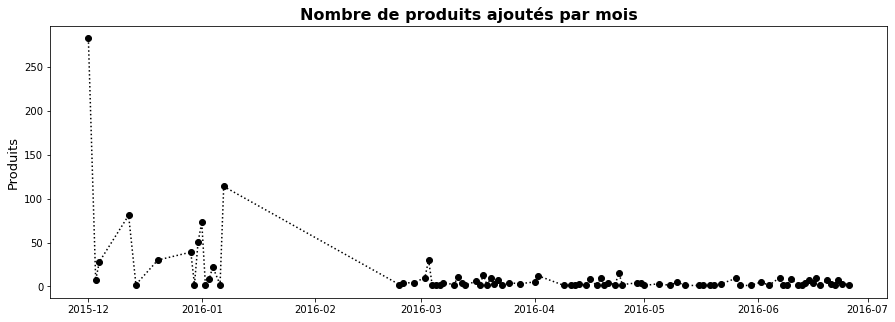

In [18]:
df_date = data.groupby(['crawl_timestamp'])['uniq_id'].count().reset_index()

plt.figure(figsize=(15, 5))
plt.plot(df_date['crawl_timestamp'], df_date['uniq_id'],
         marker='o', color='black', linestyle='dotted')
plt.xlabel('')
plt.ylabel('Produits')
plt.title("Nombre de produits ajoutés par mois")
plt.show()

In [19]:
# Fonction permettant de rajouter les étiquette en haut de chaque barre

def etiquette_v(ax, espace=5):
    """Ajoute les étiquettes en haut de chaque barre sur un barplot vertical.

    Arguments:
        ax (matplotlib.axes.Axes): objet matplotlib ocontenant les axes
            du plot à annoter.
        espace (int): distance entre les étiquettes et les barres.
    """

    # Pour chaque barre, placer une étiquette
    for rect in ax.patches:
        # Obtenir le placement de X et Y de l'étiquette à partir du rectangle
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Espace entre la barre et le label
        space = espace
        # Alignement vertical
        va = 'bottom'

        # Si la valeur est négative, placer l'étiquette sous la barre
        if y_value < 0:
            # Valeur opposer de l'argument espace
            space *= -1
            # Alignement vertical 'top'
            va = 'top'

        # Utiliser la valeur Y comme étiquette et formater avec 0 décimale
        label = "{:.0f}".format(y_value)

        # Créer l'annotation
        ax.annotate(
            label,
            (x_value, y_value),
            xytext=(0, space),
            textcoords="offset points",
            ha='center',
            va=va)

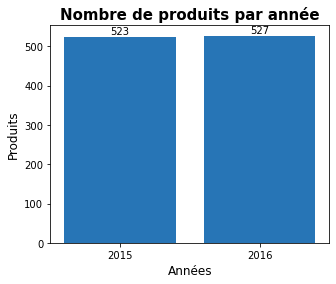

In [20]:
df_year = data.groupby(['year'])['uniq_id'].count().reset_index()

plt.figure(figsize=(5, 4))
ax = sns.barplot(x='year', y='uniq_id', data=df_year, color='#0f77ce')
plt.title('Nombre de produits par année', fontweight='bold', fontsize=15)
plt.xlabel("Années", fontsize=12)
plt.ylabel("Produits", fontsize=12)
etiquette_v(ax, 1)

<div class="alert alert-block alert-warning">
    <p>Lien internet des produits (url)</p>
</div>

In [21]:
data['product_url'].sample(3)

601    http://www.flipkart.com/posterchacha-ishita-personalised-custom-name-happy-birthday-gift-tea-coffee-use-ceramic-mug/p/itmejwbreykjes2b?pid=MUGEJWBRFZJHGSBG
633                                              http://www.flipkart.com/jacadi-paris-baby-girl-s-gathered-dark-blue-dress/p/itmejfhxedg8y6e3?pid=DREEJFHXWZDFYBGH
58                                      http://www.flipkart.com/rythmx-fb-nail-polishes-black-lipsticks-important-combo-60/p/itmej3anjrcvynq9?pid=CBKEJ3ANG8NRZJPT
Name: product_url, dtype: object

In [22]:
data[['product_url', 'product_name', 'pid']].sample(3)

,product_url,product_name,pid
86,http://www.flipkart.com/oxford-tawa-15-cm-diameter/p/itmejqr9e5a58yvz?pid=PTPEJQR9VKFUV4HY,oxford Tawa 15 cm cm diameter,PTPEJQR9VKFUV4HY
677,http://www.flipkart.com/simoco-7-w-9-12-w-led-bulb/p/itmeeb6hghgzpfhe?pid=BLBEEB6HBDZGRHE9,"Simoco 7 W, 9 W, 12 W LED Bulb",BLBEEB6HBDZGRHE9
966,http://www.flipkart.com/checkered-chef-steel-all-purpose-scissor/p/itmej7wdvct9dpxv?pid=KISEJ7WDQY499TQE,Checkered Chef Steel All-Purpose Scissor,KISEJ7WDQY499TQE


Le lien renvoie vers le site e-commerce indien flipkart mais les produits ne sont plus disponibles car trop anciens. L'url est composée du nom du produit et de la variable pid. Ces deux variables ne seront pas conservées

<div class="alert alert-block alert-warning">
    <p>product_category_tree</p>
</div>

In [23]:
# 2 examples de product_category_tree
data['product_category_tree'].sample(2).tolist()

['["Watches >> Wrist Watches >> Pittsburgh Polo Club Wrist Watches >> Pittsburgh Polo Club PBPC-505-GRN Analog Watch  ..."]',
 '["Watches >> Wrist Watches >> Jack klein Wrist Watches"]']

Nous remarquons que le product_category_tree possède plusieurs niveaux identifiables grâce au signe >> et que les produits ne possèdent pas tous le même nombre de niveaux. Nous allons créer x colonnes supplémentaires correspondant au nombre maximum de niveaux et splitter et affecter chaque niveau dans la bonne colonne.

In [24]:
def split_and_add_columns(df, var, sep):

    # Split des catégories en x colonnes
    df_cat = df[var].str.split(sep, expand=True)
    len_df_cat = len(df_cat.columns.tolist())

    # Modification automatique du nom des colonnes
    for i in range(0, len_df_cat):
        df_cat = df_cat.rename(columns={df_cat.columns[i]:
                                        'Cat_' + str(i)})

    # Assemblage des 2 dataframes
    df_new = pd.concat([df, df_cat], sort=False, axis=1)

    # Nettoyage des ["
    df_new.replace('\\["', '', regex=True, inplace=True)
    df_new.replace('"\\]', '', regex=True, inplace=True)

    return df_new

In [25]:
data = split_and_add_columns(data, 'product_category_tree', ' >> ')
data.head(2)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,...,brand,product_specifications,year,Cat_0,Cat_1,Cat_2,Cat_3,Cat_4,Cat_5,Cat_6
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30,http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdgthcts?pid=CRNEG7BKMFFYHQ8Z,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do...,CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,...,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""Elegance""}, {""key""=>""Designed For"", ""value""=>""Door""}, {""key""=>""Type"", ""value""=>""Eyelet""}, {""key""=>""Model Name"", ""value""=>""Abstract Polyester Door Curtain Set Of 2""}, {""key""=>""Model ID"", ""value""=>""Duster25""}, {""key""=>""Color"", ""value""=>""Multicolor""}, {""key""=>""Length"", ""value""=>""213 cm""}, {""key""=>""Number of Contents in Sales Package"", ""value""=>""Pack of 2""}, {""key""=>""Sales Package"", ""value""=>""2 Curtains""}, {""key""=>""Material"", ""value""=>""Polyester""}]}",2016,Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet Do...,None,None,None
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30,http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH,Sathiyas Cotton Bath Towel,"Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,...,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Washable"", ""value""=>""Yes""}, {""key""=>""Material"", ""value""=>""Cotton""}, {""key""=>""Design"", ""value""=>""Self Design""}, {""key""=>""Brand"", ""value""=>""Sathiyas""}, {""key""=>""Type"", ""value""=>""Bath Towel""}, {""key""=>""GSM"", ""value""=>""500""}, {""key""=>""Model Name"", ""value""=>""Sathiyas cotton bath towel""}, {""key""=>""Ideal For"", ""value""=>""Men, Women, Boys, Girls""}, {""key""=>""Model ID"", ""value""=>""asvtwl322""}, {""key""=>""Color"", ""value""=>""Red, Yellow, Blue""}, {""key""=>""Size"", ""value""=>""Mediam""}, {""key""=>""Length"", ""value""=>""30 inch""}, {""key""=>""Width"", ""value""=>""60 inch""}, {""key""=>""Number of Contents in Sales Package"", ""value""=>""3""}, {""key""=>""Sales Package"", ""value""=>""3 Bath Towel""}]}",2016,Baby Care,Baby Bath & Skin,Baby Bath Towels,Sathiyas Baby Bath Towels,"Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y...",None,None


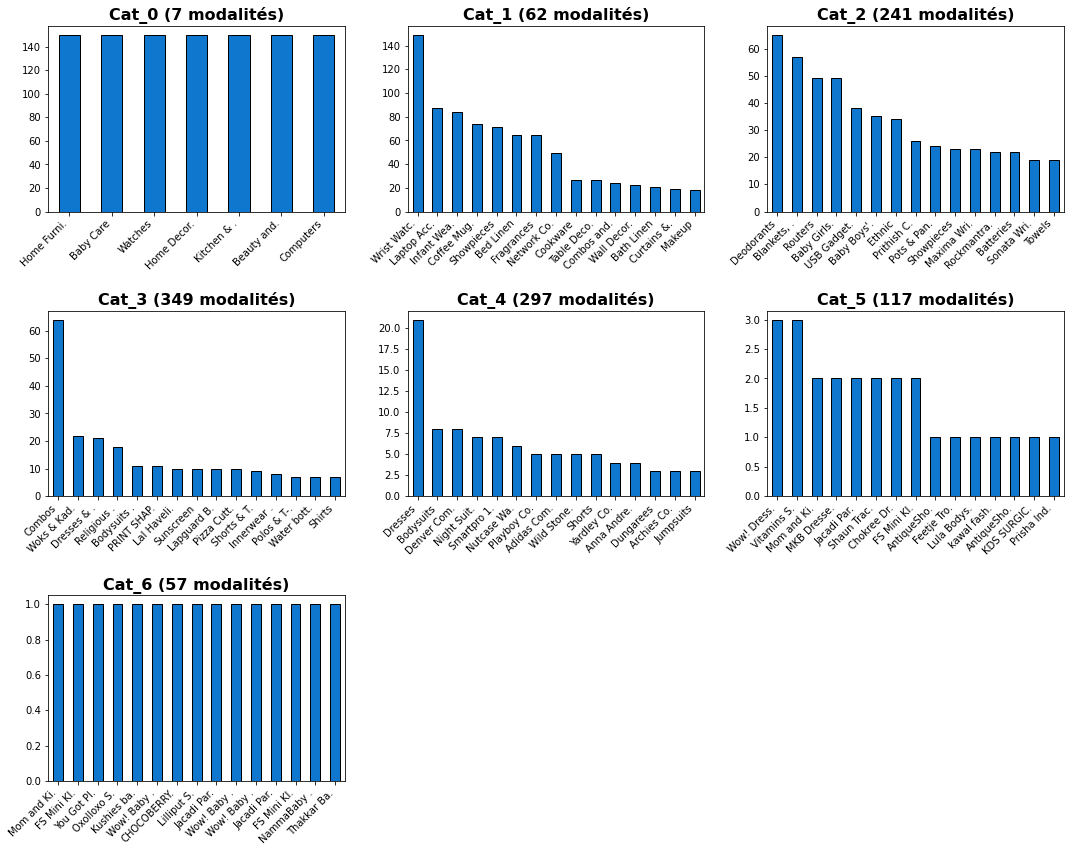

In [26]:
# Distribution des catégories
liste_categ = data.iloc[:, data.columns.str.startswith(
    'Cat')].columns.tolist()

fig = plt.figure(figsize=(15, 15))
for i, c in enumerate(liste_categ, 1):
    ax = fig.add_subplot(4, 3, i)
    modalites = data[c].value_counts()
    n_modalites = modalites.shape[0]

    if n_modalites > 15:
        modalites[0:15].plot.bar(color='#0f77ce', edgecolor='black', ax=ax)

    else:
        modalites.plot.bar(color='#0f77ce', edgecolor='black')

    ax.set_title(f'{c} ({n_modalites} modalités)', fontweight='bold')
    label = [item.get_text() for item in ax.get_xticklabels()]
    short_label = [lab[0:10] + '.' if len(lab) > 10 else lab for lab in label]
    ax.axes.set_xticklabels(short_label)
    plt.xticks(rotation=45, ha='right')

plt.tight_layout(w_pad=2, h_pad=2)

- les produits comportent une catégorie principale et jusqu'à 6 sous-catégories supplémentaires
- seul le niveau principal Cat_0 comporte 7 catégories qui sont distribuées de manière homogène comportant chacunes 150 images

Nous allons donc utiliser le **Cat_0** pour la suite de nos analyses.

<div class="alert alert-block alert-warning">
    <p>image</p>
</div>

Il serait intéressant de vérifier que pour chaque produit de ce dataset, nous retrouvons bien sa photo dans le dosier image:

In [27]:
# images de la colonne image
image = []
for img in data['image']:
    image.append(img)

# images présentes dans le dossier Images
dossier_image = []
for photo in os.listdir('data/Images'):
    dossier_image.append(photo)

In [28]:
# Eléments uniques de la colonne image
difference_1 = set(image).difference(set(dossier_image))

# Eléments uniques du dossier Images
difference_2 = set(dossier_image).difference(set(image))

print(f'Image uniquement dans la colonne image: \n {difference_1}')
print('------------------------------------------------------------------')
print(f'Image uniquement dans le dossier Images: \n {difference_2}')

Image uniquement dans la colonne image: 
 set()
------------------------------------------------------------------
Image uniquement dans le dossier Images: 
 set()


Tous les produits ont bien une image associée.

<div class="alert alert-block alert-warning">
    <p>brand</p>
</div>

La marque semble être en première position du product_name:

In [29]:
data[['product_name', 'brand']].sample(3)

,product_name,brand
258,Ruchikainternational ruc0015 Showpiece - 4 cm,Ruchikainternational
230,Sovam International Krishna With Cow Idol Showpiece - 6 cm,Sovam International
160,Rockmantra Classic Vintage Black Car Ceramic Mug,NaN


Nous allons extraire le premier élément du product_name et le comparer à la marque afin de vérifier notre constat. Nous filtrons d'abord le dataset sur les lignes où la marque est indiquée.

In [30]:
# Filtre sur les marques non nulles
df_brand = data[~data['brand'].isna()]

# Création de 2 listes avec le 1er élément des colonnes product_name et brand
l1 = [i.split(' ')[0] for i in df_brand['product_name'].tolist()]
l2 = [i.split(' ')[0] for i in df_brand['brand'].tolist()]

In [31]:
# Eléments uniques de la liste brand
difference_2 = set(l2).difference(set(l1))

print(f'Marques uniquement dans la colonne brand: \n {difference_2}')

Marques uniquement dans la colonne brand: 
 {'STYLE', 'Mega', 'Shoperite', 'Urban'}


La quasi totalité des marques est reprise dans le nom du produit.

<div class="alert alert-block alert-warning">
    <p>Observations</p>
</div>

Le fichier est composé de 1050 lignes et 15 colonnes et comporte peu de données manquantes (sauf sur la variable brand). Il n'y a aucun doublon. Les produits ont été rajoutés entre le 01 décembre 2015 et le 26 juin 2016, équitablement entre les deux années et de manière plus régulière depuis mars 2016. Chaque produit est illustré par une image, possède une description et est associé à une catégorie principale et des catégories secondaires. Seule la catégorie principale sera utilisée dans la suite de ce projet afin d'avoir un jeu de données équilibré.

Les colonnes qui vont nous intéresser sont:
- **uniq_id et product_name** => identifiants uniques du produit
- **Cat_0** => catégorie la plus équilibrée (150 produits par catégorie)
- **image** => nom de l'image associée au produit présente dans le dossier Images
- **description** => pour choisir la catégorie à laquelle affecter le produit

Les colonnes suivantes ne seront pas conservées:
- **crawl_timestamp** => ne permet pas d'identifier un produit
- **product_url** => le lien ne fonctionne pas et cette rubrique est constituée des variables product_name et pid
- **pid** => pas d'information sur cette variable et non précise
- **brand** => marque du produit pouvant aider à son identification
- **retail_price et discounted_price** => pourrait permettre de classer un produit en fonction de son prix mais ce n'est pas le travail demandé ici
- **is_FK_Advantage_product** => ne permet pas d'identifier un produit
- **product_rating et overall_rating** => ne permet pas d'identifier un produit
- **product_specifications** => redondant avec la colonne description et moins complet

In [32]:
# Dataset réduit
data_txt = data[['uniq_id', 'product_name',
                 'Cat_0', 'description',
                 'image']]
data_txt.head(2)

,uniq_id,product_name,Cat_0,description,image
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,Home Furnishing,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you get the right amount of sunlight.,Specifications of Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) General Brand Elegance Designed For Door Type Eyelet Model Name Abstract Polyester Door Curtain Set Of 2 Model ID Duster25 Color Multicolor Dimensions Length 213 cm In the Box Number of Contents in Sales Package Pack of 2 Sales Package 2 Curtains Body & Design Material Polyester",55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,Baby Care,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel",7b72c92c2f6c40268628ec5f14c6d590.jpg


## Nettoyage des données textuelles <a class="anchor" id="txt"></a>

La première étape du traitement des données est de récupérer le corpus de textes, de faire une analyse exploratoire afin de bien comprendre les spécificités du jeu de données, et de nettoyer les données afin de pouvoir les utiliser ultérieurement dans nos algorithmes.

- le **corpus** : un ensemble de documents (ici la colonne description), regroupés dans une optique ou dans une thématique précise
- un **document** : la notion de document fait référence à un texte appartenant au corpus, mais indépendant des autres textes. Il peut être constitué d'une ou plusieurs phrases, un ou plusieurs paragraphes (ici chaque cellule de la colonne description)
- un **token** : le terme token désigne généralement un mot et/ou un élément de ponctuation
- le **vocabulaire** : il s'agit de l'ensemble des tokens distincts présents dans l'ensemble du corpus

#### Corpus

Nous récupérons dans un premier temps le corpus (colonne description) et effectuons un premier traitement de ce dernier pour avoir des données textuelles exploitables (au format string).

In [33]:
corpus_des = ' '.join([txt for txt in data_txt["description"]])
corpus_des[0:1000]

'Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you

#### Tokenization

Il s'agit du découpage en mots des différents documents qui constituent le corpus (la colonne description).
Dans un premier temps, on souhaite étudier le vocabulaire utilisé dans les descriptions par catégorie. Pour une première intuition, il est judicieux d'observer le nombre de mots utilisés.

Explication du regex utilisé:
- r => case sensitive
- \w => lettres et chiffres (équivalent à [a-zA-Z0-9_])
- "+" => caractère présent autant de fois que possible

In [34]:
corpus_token = RegexpTokenizer(r"\w+").tokenize(corpus_des)
print(corpus_token[0:300])

['Key', 'Features', 'of', 'Elegance', 'Polyester', 'Multicolor', 'Abstract', 'Eyelet', 'Door', 'Curtain', 'Floral', 'Curtain', 'Elegance', 'Polyester', 'Multicolor', 'Abstract', 'Eyelet', 'Door', 'Curtain', '213', 'cm', 'in', 'Height', 'Pack', 'of', '2', 'Price', 'Rs', '899', 'This', 'curtain', 'enhances', 'the', 'look', 'of', 'the', 'interiors', 'This', 'curtain', 'is', 'made', 'from', '100', 'high', 'quality', 'polyester', 'fabric', 'It', 'features', 'an', 'eyelet', 'style', 'stitch', 'with', 'Metal', 'Ring', 'It', 'makes', 'the', 'room', 'environment', 'romantic', 'and', 'loving', 'This', 'curtain', 'is', 'ant', 'wrinkle', 'and', 'anti', 'shrinkage', 'and', 'have', 'elegant', 'apparance', 'Give', 'your', 'home', 'a', 'bright', 'and', 'modernistic', 'appeal', 'with', 'these', 'designs', 'The', 'surreal', 'attention', 'is', 'sure', 'to', 'steal', 'hearts', 'These', 'contemporary', 'eyelet', 'and', 'valance', 'curtains', 'slide', 'smoothly', 'so', 'when', 'you', 'draw', 'them', 'apart'

In [35]:
def nb_tokens(txt):
    print("Nombre de tokens: {}".format(len(txt)))
    print("Nombre de tokens uniques: {}".format(len(set(txt))))

In [36]:
nb_tokens(corpus_token)

Nombre de tokens: 81563
Nombre de tokens uniques: 7670


- On retrouve des nombres seuls ou accolés à un mot (Duster25, 213...)
- Les mêmes mots peuvent avoir une majuscule ou non
- Certains mots n'apportent aucune précision et doivent être écartés: to, the, and etc
- La langue utilisée est l'anglais

#### Normalisation

Le fait d'essayer d'harmoniser les tokens est un processus nommé « normalisation ». Nous allons ici:
- passer le texte en minuscule,
- supprimer les espaces avant et après chaque token,
- récupérer les caractères alphanumériques (les caractères spéciaux / ponctuation ne seront pas pris),
- filtrer les "Stop Words" (mots à ignorer tels que: in, of, the...),
- ne garder que les tokens ayant 2 lettres ou plus
- ne garder que les lettres 

Toutes ces étapes seront intégrées dans une même fonction.

In [37]:
def clean_txt_1(text,
                stop_words="english",
                min_len_word=2,
                only_alpha=True):
    
    '''Natural Language Processing basic function.

    positional arguments:
    ------------------------
    text: str: text in a str format to process

    opt args:
    ------------------------
    stop_words : str: language of the stopwords
    min_len_word : int : the minimum length of words to keep
    only_alpha : bool : if True, exclude all tokens with a numeric character

    return:
    ------------------------
    a list of tokens'''

    # lower and strip
    doc = text.lower().strip()

    # Tokenize
    # tokenizer = RegexpTokenizer("[A-Za-z0-9]\w+")
    # tokenizer = RegexpTokenizer("[A-Za-z]\w+")
    tokenizer = RegexpTokenizer(r"\w+")
    raw_tokens_list = tokenizer.tokenize(doc)

    # Remove stopwords
    stop_words = set(stopwords.words(stop_words))
    clean_tokens_list = [w for w in raw_tokens_list if w not in stop_words]

    # Keep only len word > N
    more_than_N = [w for w in clean_tokens_list if len(w) >= min_len_word]

    # Keep only alpha not num
    if only_alpha == True:
        alpha_num = [w for w in more_than_N if w.isalpha()]
    else:
        alpha_num = more_than_N

    return alpha_num

In [38]:
corpus_norm = clean_txt_1(corpus_des)
print(corpus_norm[0:300])

['key', 'features', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'cm', 'height', 'pack', 'price', 'rs', 'curtain', 'enhances', 'look', 'interiors', 'curtain', 'made', 'high', 'quality', 'polyester', 'fabric', 'features', 'eyelet', 'style', 'stitch', 'metal', 'ring', 'makes', 'room', 'environment', 'romantic', 'loving', 'curtain', 'ant', 'wrinkle', 'anti', 'shrinkage', 'elegant', 'apparance', 'give', 'home', 'bright', 'modernistic', 'appeal', 'designs', 'surreal', 'attention', 'sure', 'steal', 'hearts', 'contemporary', 'eyelet', 'valance', 'curtains', 'slide', 'smoothly', 'draw', 'apart', 'first', 'thing', 'morning', 'welcome', 'bright', 'sun', 'rays', 'want', 'wish', 'good', 'morning', 'whole', 'world', 'draw', 'close', 'evening', 'create', 'special', 'moments', 'joyous', 'beauty', 'given', 'soothing', 'prints', 'bring', 'home', 'elegant', 'curtain', '

In [39]:
nb_tokens(corpus_norm)

Nombre de tokens: 55067
Nombre de tokens uniques: 4881


Regardons à présent la fréquence d'apparition des mots:

In [40]:
freq_words = collections.Counter(corpus_norm)
freq_words = pd.DataFrame.from_dict(freq_words,
                                    orient='index').rename(
    columns={0:'Occurences'}).reset_index()
freq_words = freq_words.sort_values(by='Occurences',
                                    ascending=False).reset_index(drop=True)
freq_words.head(20)

,index,Occurences
0,rs,911
1,products,631
2,free,618
3,buy,581
4,delivery,567
5,cash,564
6,shipping,564
7,genuine,564
8,replacement,559
9,cm,543


On note que certains mots sont inutiles et ne vont pas permettre la classification des produits dans des catégories. Ils n'apportent pas de valeur informative pour la compréhension du "sens" d'un document et corpus. C'est le cas des premiers mots les plus fréquents. Nous allons les considérer comme des stopwords et les supprimer de notre corpus:

In [41]:
# Mots à supprimer:
newStopWords = freq_words['index'].iloc[0:18].tolist()
print(newStopWords)

['rs', 'products', 'free', 'buy', 'delivery', 'cash', 'shipping', 'genuine', 'replacement', 'cm', 'day', 'flipkart', 'com', 'guarantee', 'online', 'features', 'specifications', 'price']


In [42]:
# Corpus retraité des mots inutiles
corpus_norm = [w for w in corpus_norm if w not in newStopWords]

In [43]:
# Vérification des 30 mots les plus fréquents
print(collections.Counter(corpus_norm).most_common(30))

[('watch', 330), ('color', 328), ('mug', 327), ('baby', 320), ('pack', 317), ('material', 312), ('set', 310), ('type', 304), ('cotton', 299), ('box', 292), ('general', 288), ('package', 269), ('analog', 262), ('sales', 261), ('number', 253), ('warranty', 250), ('quality', 245), ('details', 235), ('product', 233), ('brand', 232), ('best', 230), ('model', 226), ('design', 225), ('ceramic', 219), ('key', 215), ('laptop', 214), ('fabric', 211), ('prices', 209), ('showpiece', 206), ('made', 189)]


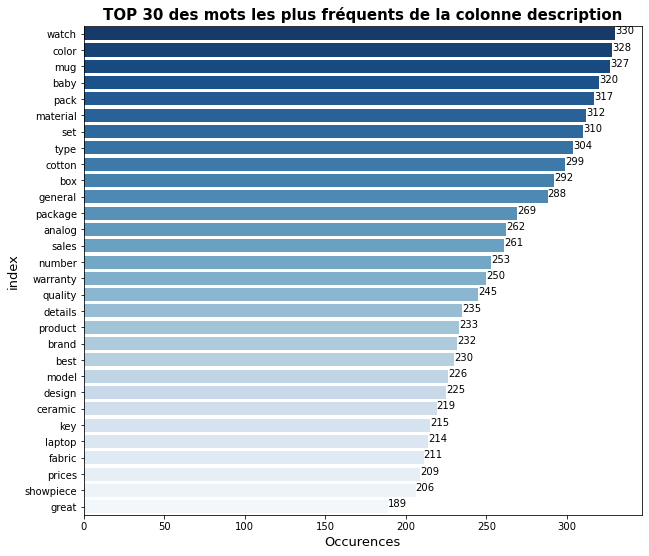

In [44]:
freq_words = freq_words[18:]

plt.figure(figsize=(10, 9))
ax = sns.barplot(y='index',
                 x='Occurences',
                 data=freq_words.head(30),
                 palette='Blues_r')
plt.title('TOP 30 des mots les plus fréquents de la colonne description',
          fontweight='bold',
          fontsize=15)

total = len(freq_words['index'].iloc[0:30])
for p in ax.patches:
    etiquette = '{:,.0f}'.format(p.get_width())
    width, height = p.get_width(), p.get_height()
    x = p.get_x()+width+0.02
    y = p.get_y()+height/2
    ax.annotate(etiquette, (x, y))

Voyons maintenant les mots les moins présents:

In [45]:
token_nb = pd.Series(corpus_norm).value_counts()
token_nb.describe()

count    4863.000000
mean        9.353486
std        26.576912
min         1.000000
25%         1.000000
50%         2.000000
75%         6.000000
max       330.000000
dtype: float64

La distributions des tokens est asymétrique avec 50% des tokens présents 2 fois, 75% des tokens présents 6 fois avec un maximum de 330 fois. Comme il y a de grandes chances que lors de la réduction de dimension ces tokens soient écartés, supprimons les dès à présent.

In [46]:
# Liste des mots uniques
list_unique_words = token_nb[token_nb == 1]
list_unique_words[:20]

dropping        1
mx              1
acer            1
structure       1
covering        1
liabilities     1
oppurtunity     1
loss            1
derivatives     1
wowan           1
ingress         1
lightening      1
creases         1
flatware        1
existing        1
robinson        1
numbers         1
entertaining    1
ms              1
narmal          1
dtype: int64

In [47]:
# Nombre de mots uniques
len(list_unique_words)

1436

In [48]:
# Sauvegarde des mots qui apparaissent une fois dans le corpus
# list_unique_words = pd.DataFrame({"words" : list_unique_words})
# list_unique_words.to_csv('data/unique_words.csv', index=False)

Nous allons rajouter à notre fonction la possibilité de supprimer une liste de mots à considérer comme des stopwords et une liste de mots qui n'apparaissent que x fois dans le corpus:

In [49]:
def clean_txt_2(text,
                stop_words="english",
                min_len_word=2,
                only_alpha=True,
                extra_words=None,
                list_rare_words=None):
    
    '''Natural Language Processing basic function.
    
    positional arguments:
    ------------------------
    text: str: text in a str format to process
    
    opt args:
    ------------------------
    stop_words : str: language of the stopwords
    min_len_word : int : the minimum length of words to keep
    only_alpha : bool : if True, exclude all tokens with a numeric character
    extra_words : list : words to exclude and consider as stopwords
    list_rare_words : list : list of rare words to exclude
    
    return:
    ------------------------
    a list of tokens'''

    # extra_words
    if not extra_words:
        extra_words = []

    # list_rare_words
    if not list_rare_words:
        list_rare_words = []

    # lower and strip
    doc = text.lower().strip()

    # Tokenize
    # tokenizer = RegexpTokenizer("[A-Za-z0-9]\w+")
    # tokenizer = RegexpTokenizer("[A-Za-z]\w+")
    tokenizer = RegexpTokenizer(r"\w+")
    raw_tokens_list = tokenizer.tokenize(doc)

    # Remove stopwords
    # stop_words = list(set(stopwords.words(stop_words)))
    stop_words = set(stopwords.words(stop_words))
    clean_tokens_list = [w for w in raw_tokens_list if w not in stop_words]

    # Keep only len word > N
    more_than_N = [w for w in clean_tokens_list if len(w) >= min_len_word]

    # Keep only alpha not num
    if only_alpha == True:
        alpha_num = [w for w in more_than_N if w.isalpha()]
    else:
        alpha_num = more_than_N

    # Drop extra_words tokens
    extra_w = [w for w in alpha_num if w not in extra_words]
    
    # No rare tokens
    non_rare_tokens = [w for w in extra_w if w not in list_rare_words]

    return non_rare_tokens

In [50]:
corpus_norm = clean_txt_2(corpus_des,
                          stop_words="english",
                          min_len_word=2,
                          only_alpha=True,
                          extra_words=newStopWords,
                          list_rare_words=list_unique_words.index.tolist())
print(corpus_norm[0:300])

['key', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'height', 'pack', 'curtain', 'enhances', 'look', 'interiors', 'curtain', 'made', 'high', 'quality', 'polyester', 'fabric', 'eyelet', 'style', 'stitch', 'metal', 'ring', 'makes', 'room', 'environment', 'curtain', 'ant', 'wrinkle', 'anti', 'shrinkage', 'elegant', 'give', 'home', 'bright', 'appeal', 'designs', 'attention', 'sure', 'contemporary', 'eyelet', 'curtains', 'slide', 'smoothly', 'draw', 'apart', 'first', 'thing', 'morning', 'welcome', 'bright', 'sun', 'rays', 'want', 'wish', 'good', 'morning', 'whole', 'world', 'draw', 'evening', 'create', 'special', 'moments', 'beauty', 'given', 'soothing', 'prints', 'bring', 'home', 'elegant', 'curtain', 'light', 'room', 'get', 'right', 'amount', 'sunlight', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'height', 'pack', 'ge

In [51]:
nb_tokens(corpus_norm)

Nombre de tokens: 44050
Nombre de tokens uniques: 3427


#### Lemmatization

Le processus de « lemmatisation » consiste à représenter les mots sous leur forme canonique. Par exemple pour un verbe, ce sera son infinitif. Pour un nom, son masculin singulier. L'idée étant encore une fois de ne conserver que le sens des mots utilisés dans le corpus.

In [52]:
lemmatizer = WordNetLemmatizer()
corpus_token_lem = [lemmatizer.lemmatize(w) for w in corpus_norm]
print(corpus_token_lem[0:300])

['key', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'height', 'pack', 'curtain', 'enhances', 'look', 'interior', 'curtain', 'made', 'high', 'quality', 'polyester', 'fabric', 'eyelet', 'style', 'stitch', 'metal', 'ring', 'make', 'room', 'environment', 'curtain', 'ant', 'wrinkle', 'anti', 'shrinkage', 'elegant', 'give', 'home', 'bright', 'appeal', 'design', 'attention', 'sure', 'contemporary', 'eyelet', 'curtain', 'slide', 'smoothly', 'draw', 'apart', 'first', 'thing', 'morning', 'welcome', 'bright', 'sun', 'ray', 'want', 'wish', 'good', 'morning', 'whole', 'world', 'draw', 'evening', 'create', 'special', 'moment', 'beauty', 'given', 'soothing', 'print', 'bring', 'home', 'elegant', 'curtain', 'light', 'room', 'get', 'right', 'amount', 'sunlight', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'height', 'pack', 'general',

In [53]:
nb_tokens(corpus_token_lem)

Nombre de tokens: 44050
Nombre de tokens uniques: 3155


#### Fonction globale de traitement du texte

Afin de pouvoir analyser les mots principaux par catégorie puis appliquer ensuite la réduction de dimension puis le clustering, appliquons nos étapes de nettoyage par ligne de la colonne description. Mettons tout d'abord à jour notre fonction de nettoyage en rajoutant la possibilité de lemmatiser ou de stemmatiser, de ne retourner que des mots anglais et de retourner non pas une liste mais une chaine de caractère:

In [54]:
eng_words = [i.lower() for i in words.words()]
lm = WordNetLemmatizer()
eng_words_lem = [lm.lemmatize(i) for i in eng_words]

In [55]:
def clean_txt_3(text,
                join=True,
                lemm_or_stemm=None,
                stop_words="english",
                eng_words=None,
                min_len_word=2,
                only_alpha=True,
                extra_words=None,
                list_rare_words=None):
    
    '''Natural Language Processing basic function.

    positional arguments:
    ------------------------
    text: str: text in a str format to process

    opt args:
    ------------------------
    join : bool : if True, return a string else return the list of tokens
    lemm_or_stemm : str : if lemm do lemmentize else stemmentize
    stop_words : str: language of the stopwords
    eng_words : list : list of english words
    min_len_word : int : the minimum length of words to keep
    only_alpha : bool : if True, exclude all tokens with a numeric character
    extra_words : list : words to exclude and consider as stopwords
    list_rare_words : list : list of rare words to exclude

    return:
    ------------------------
    a list of tokens'''

    # extra_words
    if not extra_words:
        extra_words = []

    # eng_words
    if not eng_words:
        eng_words = []

    # list_rare_words
    if not list_rare_words:
        list_rare_words = []

    # lower and strip
    doc = text.lower().strip()

    # Tokenize
    # tokenizer = RegexpTokenizer("[A-Za-z0-9]\w+")
    # tokenizer = RegexpTokenizer("[A-Za-z]\w+")
    tokenizer = RegexpTokenizer(r"\w+")
    raw_tokens_list = tokenizer.tokenize(doc)

    # Remove stopwords
    # stop_words = list(set(stopwords.words(stop_words)))
    stop_words = set(stopwords.words(stop_words))
    clean_tokens_list = [w for w in raw_tokens_list if w not in stop_words]

    # Drop extra_words tokens
    extra_w = [w for w in clean_tokens_list if w not in extra_words]

    # No rare tokens
    non_rare_tokens = [w for w in extra_w if w not in list_rare_words]

    # Keep only len word > N
    more_than_N = [w for w in non_rare_tokens if len(w) >= min_len_word]

    # Keep only alpha not num
    if only_alpha == True:
        alpha_num = [w for w in more_than_N if w.isalpha()]
    else:
        alpha_num = more_than_N

    # Stemm or Lemm
    if lemm_or_stemm == "lemm":
        trans = WordNetLemmatizer()
        trans_txt = [trans.lemmatize(i) for i in alpha_num]
    elif lemm_or_stemm == "stemm":
        trans = PorterStemmer()
        trans_txt = [trans.stem(i) for i in alpha_num]
    else:
        trans_txt = alpha_num

    # English words
    if eng_words:
        engl_txt = [i for i in trans_txt if i in eng_words]
    else:
        engl_txt = trans_txt
        
    # Return a list or a string
    if join:
        return " ".join(engl_txt)

    return engl_txt

#### Nettoyage des colonnes description et product_name

In [56]:
# Colonne description nettoyée et lemmatisée
list_rare_words = list_unique_words.index.tolist()

data_txt['desc_clean_lem'] = [clean_txt_3(
    row,
    join=True,
    lemm_or_stemm="lemm",
    stop_words="english",
    eng_words=None,
    min_len_word=2,
    only_alpha=True,
    extra_words=newStopWords,
    list_rare_words=list_rare_words) for row in data_txt['description']]

C:\Users\milie\AppData\Local\Temp\ipykernel_11768\3906961592.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_txt['desc_clean_lem'] = [clean_txt_3(


In [57]:
# Colonne description nettoyée et non lemmatisée
data_txt['desc_clean'] = [clean_txt_3(
    row,
    join=True,
    lemm_or_stemm=None,
    stop_words="english",
    eng_words=None,
    min_len_word=2,
    only_alpha=True,
    extra_words=newStopWords,
    list_rare_words=list_rare_words) for row in data_txt['description']]

C:\Users\milie\AppData\Local\Temp\ipykernel_11768\703745362.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_txt['desc_clean'] = [clean_txt_3(


In [58]:
# 5 exemples
data_txt[['description', 'desc_clean_lem', 'desc_clean']].sample(5)

,description,desc_clean_lem,desc_clean
70,"Key Features of Caffeine Handmade Tribal Print Influenced Katori Bowl (Set of 2) Stoneware Bowl Set Tip to bottom is 100% handmade with fine details. Dessert bowls used for vegetables, fruits, custards, snacks etc. Material: Ceramic/Stoneware Capacity: 400ml each Note: Set of 2 Size:10*10*4.5,Caffeine Handmade Tribal Print Influenced Katori Bowl (Set of 2) Stoneware Bowl Set (Orange, Green, Pack of 2) Price: Rs. 699 Caffeine Ceramic Handmade Tribal Print Influenced Katori Bowl (Set of 2) This is a perfect product of handmade tribal pottery art at the same time elegant piece of ceramic works. This is a cute combination Katori set of 2 pieces with perfect glossy ceramic finish. This is beauty of hand art in the field of product, enough to highlight your serving and give your dining an elite and sweet touch. Those who love their food, love their kitchen will definitely love this modern approach to pudding and dessert bowls. Serve your guests in this after meal and get the sparkling appreciation for your fine hospitality. Tip to bottom is 100% handmade with fine details. Dessert bowls used for vegetables, fruits, custards, snacks etc. Material: Ceramic/Stoneware Capacity: 400ml each Note: Set of 2,Specifications of Caffeine Handmade Tribal Print Influenced Katori Bowl (Set of 2) Stoneware Bowl Set (Orange, Green, Pack of 2) General Brand Caffeine Model Number NT345 Type Bowl Set Model Name Handmade Tribal Print Influenced Katori Bowl (Set of 2) Bowl Type Ice Cream Bowl, Pudding Bowl, Fruit Bowl, Decorative Bowl, Soup Bowl, Vegetable Bowl, Sauce Bowl Freezer Safe Yes Microwave Safe Yes Color Orange, Green Body and Design Features Material Stoneware In the Box Sales Package 2 Bowls Pack of 2",key caffeine handmade tribal print influenced katori bowl set stoneware bowl set tip bottom handmade fine detail dessert bowl used vegetable fruit custard snack etc material ceramic stoneware capacity note set size caffeine handmade tribal print influenced katori bowl set stoneware bowl set orange green pack caffeine ceramic handmade tribal print influenced katori bowl set perfect product handmade tribal pottery art time elegant piece ceramic work cute combination katori set piece perfect glossy ceramic finish beauty hand art field product enough serving give dining elite sweet touch love food love kitchen love modern approach pudding dessert bowl serve guest get fine tip bottom handmade fine detail dessert bowl used vegetable fruit custard snack etc material ceramic stoneware capacity note set caffeine handmade tribal print influenced katori bowl set stoneware bowl set orange green pack general brand caffeine model number type bowl set model name handmade tribal print influenced katori bowl set bowl type ice cream bowl pudding bowl fruit bowl decorative bowl bowl bowl bowl freezer safe yes microwave safe yes color orange green body design material stoneware box sale package bowl pack,key caffeine handmade tribal print influenced katori bowl set stoneware bowl set tip bottom handmade fine details dessert bowls used vegetables fruits custards snacks etc material ceramic stoneware capacity note set size caffeine handmade tribal print influenced katori bowl set stoneware bowl set orange green pack caffeine ceramic handmade tribal print influenced katori bowl set perfect product handmade tribal pottery art time elegant piece ceramic works cute combination katori set pieces perfect glossy ceramic finish beauty hand art field product enough serving give dining elite sweet touch love food love kitchen love modern approach pudding dessert bowls serve guests get fine tip bottom handmade fine details dessert bowls used vegetables fruits custards snacks etc material ceramic stoneware capacity note set caffeine handmade tribal print influenced katori bowl set stoneware bowl set orange green pack general brand caffeine model number type bowl set model name handmade tribal print influenced katori bowl set bowl type 

Visualisons sous la forme d'un nuage les mots principaux par catégorie de produits (colonne desc_clean_lem):

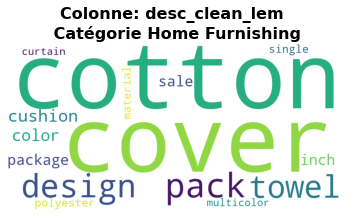

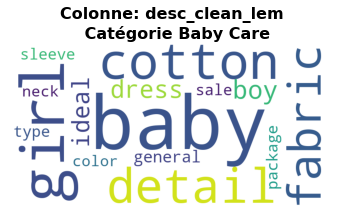

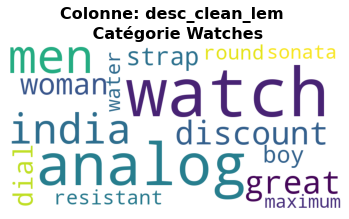

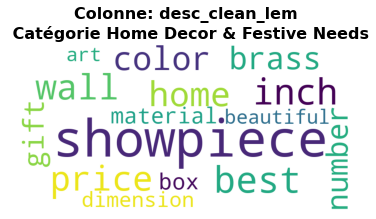

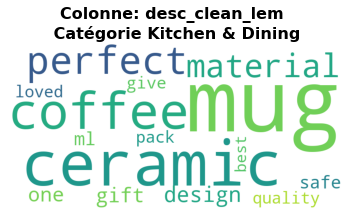

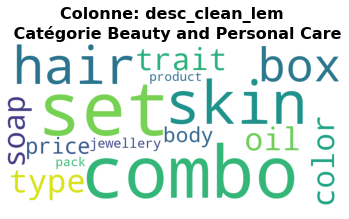

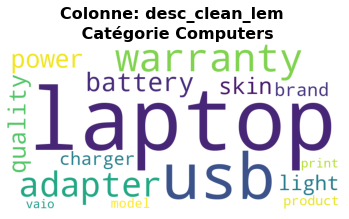

In [59]:
for mod in data_txt['Cat_0'].unique():
    df = data_txt[data_txt['Cat_0'] == mod]
    corp = ' '.join([txt for txt in df["desc_clean_lem"]])
    corp_token = nltk.word_tokenize(corp)
    wcdict = collections.Counter(corp_token)
    wordcloud = WordCloud(background_color='white',
                          max_words=15,
                          width=800,
                          height=400).generate_from_frequencies(wcdict)

    plt.figure(figsize=(6, 5))
    plt.imshow(wordcloud)
    plt.title(f"Colonne: desc_clean_lem \n Catégorie {mod}")
    plt.axis("off")

Nous allons également appliquer notre nettoyage de texte aux noms des produits:

In [60]:
# Colonne product_name nettoyée et lemmatisée
data_txt['pname_clean_lem'] = [clean_txt_3(
    row,
    join=True,
    lemm_or_stemm="lemm",
    stop_words="english",
    eng_words=None,
    min_len_word=2,
    only_alpha=True,
    extra_words=newStopWords,
    list_rare_words=list_rare_words) for row in data_txt['product_name']]

C:\Users\milie\AppData\Local\Temp\ipykernel_11768\1546224162.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_txt['pname_clean_lem'] = [clean_txt_3(


In [61]:
# Colonne product_name nettoyée et non lemmatisée
data_txt['pname_clean'] = [clean_txt_3(
    row,
    join=True,
    lemm_or_stemm=None,
    stop_words="english",
    eng_words=None,
    min_len_word=2,
    only_alpha=True,
    extra_words=newStopWords,
    list_rare_words=list_rare_words) for row in data_txt['product_name']]

C:\Users\milie\AppData\Local\Temp\ipykernel_11768\671406072.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_txt['pname_clean'] = [clean_txt_3(


In [62]:
# 5 exemples de noms de produits
data_txt[['product_name', 'pname_clean', 'pname_clean_lem']].sample(5)

,product_name,pname_clean,pname_clean_lem
477,"Cotonex Blue, White Cotton Kitchen Linen Set",cotonex blue white cotton kitchen linen set,cotonex blue white cotton kitchen linen set
598,Saco Karbonn Smart Ta Fone A37 Hd Tablet Wired USB Tablet Keyboard,smart hd tablet wired usb tablet keyboard,smart hd tablet wired usb tablet keyboard
183,Rockmantra Blue Water Abstracts Ceramic Mug,rockmantra blue water abstracts ceramic mug,rockmantra blue water abstract ceramic mug
482,ARB HP Pavilion dv5t-1000 Replacement 6 Cell Laptop Battery,arb hp pavilion cell laptop battery,arb hp pavilion cell laptop battery
96,My Angel Gifts Show Piece Showpiece - 5 cm,angel gifts show piece showpiece,angel gift show piece showpiece


Visualisons maintenant sous la forme d'un nuage les mots principaux par nom de produit (colonne pname_clean_lem):

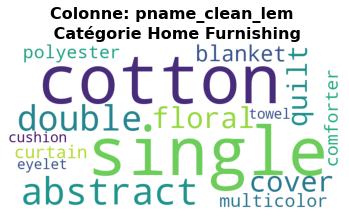

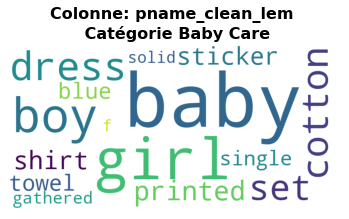

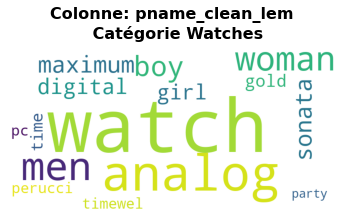

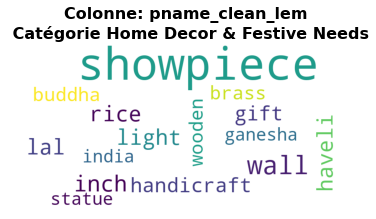

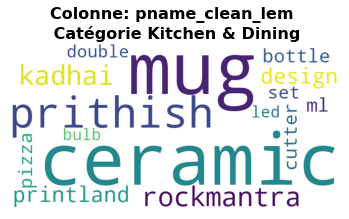

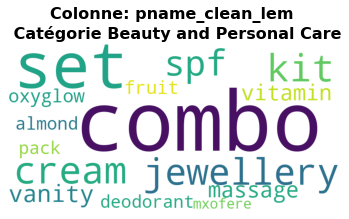

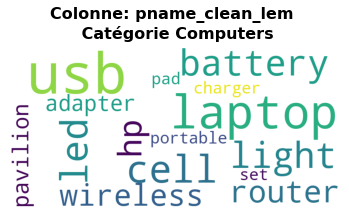

In [63]:
for mod in data_txt['Cat_0'].unique():
    df = data_txt[data_txt['Cat_0'] == mod]
    corp = ' '.join([txt for txt in df["pname_clean_lem"]])
    corp_token = nltk.word_tokenize(corp)
    wcdict = collections.Counter(corp_token)
    wordcloud = WordCloud(background_color='white',
                          max_words=15,
                          width=800,
                          height=400).generate_from_frequencies(wcdict)

    plt.figure(figsize=(6, 5))
    plt.imshow(wordcloud)
    plt.title(f"Colonne: pname_clean_lem \n Catégorie {mod}")
    plt.axis("off")

In [64]:
data_bow = data_txt.copy()

## Extraction de l'information du texte <a class="anchor" id="extract"></a>

Nous allons maintenant étudier comment **extraire l'information du texte pour le traitement ultérieur par des modèles de machine learning**. En d'autres termes, nous cherchons une **représentation du langage pour un modèle statistique** qui vise à exploiter des données textes.

### Approches de type bag of word <a class="anchor" id="bag"></a>

Le bag-of-words (sac de mots en français) consiste principalement à nettoyer les données textuelles d’une certaine manière afin de pouvoir ensuite les fournir en entrée de modèles d’apprentissage automatique.

Bien que son usage ait diminué, cette technique possède de nombreux atouts:
- très simple à comprendre
- peut être utilisé sur un faible échantillon de données alors que les techniques basées sur les réseaux de neurones ont en besoin d’énormément
- ne nécessite pas de capacités de calcul importantes (un CPU suffit alors que les techniques de réseaux de neurones nécessitent des GPUs ou des TPUs qui coûtent extrêmement chers)

Les algorithmes d’apprentissage automatique ne peuvent pas fonctionner directement avec du texte brut. **Le texte doit être converti en chiffres et notamment en vecteur. Un bag-of-words est une représentation du texte qui décrit la présence de mots dans un document**. Cela implique deux choses :
- un vocabulaire de mots connus
- une mesure de la présence des mots connus

Il s’agit d’un « sac » de mots, car toute information sur l’ordre ou la structure des mots dans le document est rejetée. Le modèle se préoccupe seulement de savoir si des mots connus se trouvent dans le document et non pas où ils se trouvent dans le document. Ainsi, le bag-of-words élimine toute l’information relative à l’ordre des mots et **met l’accent sur l’occurrence des mots dans un document**. **L’intuition est que les documents sont similaires s’ils ont un contenu similaire**. De plus, du seul contenu nous pouvons apprendre quelque chose sur la signification du document.

#### Comptage simple de mots (Countvectorizer) <a class="anchor" id="cpte"></a>

Il est utilisé pour **transformer un texte donné en un vecteur sur la base de la fréquence (nombre) de chaque mot qui apparaît dans le texte entier**. Cette méthode est utile lorsque nous disposons de plusieurs textes de ce type et que nous souhaitons convertir chaque mot de chaque texte en vecteurs (pour les utiliser dans une analyse textuelle ultérieure).

CountVectorizer crée une matrice dans laquelle **chaque mot unique est représenté par une colonne de la matrice**, et **chaque échantillon de texte du document est une ligne de la matrice**. La valeur de chaque cellule n'est rien d'autre que le **nombre de mots** dans cet échantillon de texte particulier.

Voici les différentes étapes que nous allons suivre:
- **Countvectorizer** sur données lemmatisées avec **extraction des features de la colonne descriptio**n (desc_clean_lem)
- **Analyse en composantes principales** avec choix de l'hyperparamètre n_components en fonction de l'éboulis des valeurs propres
- **t-SNE** avec 2 composantes et optimisation de l'hyperparamètre perplexity
- **KMeans** avec 7 clusters pour représenter nos 7 catégories
- Calcul de l'**Adjusted Rand Index** (ARI) et **visualisation** en 2 dimensions des produits par catégories réelles vs produits par clusters
- Nous reproduirons ensuite toutes ces étapes sur données lemmatisées avec **extraction des features de la colonne product_name** (pname_clean_lem) et **product_name + description** (pname_desc_clean_lem) et choisirons la méthode avec le meilleur ARI.
- Nous referons tourner notre modèle sur les données avec un **autre preprocessing** (données non lemmatisées) afin de voir le plus performant

##### Countvectorizer sur données lemmatisées avec extraction des features de la colonne description (desc_clean_lem)

<div class="alert alert-block alert-warning">
    <p>Countvectorizer</p>
</div>

In [65]:
def bag_of_word(df, df_index, feature_fit, feature_trans, model):
    # Initialisation
    mod = model
    # Extraction features du texte
    mod_fit = mod.fit(df[feature_fit])
    # Vectorisation (encodage du document)
    mod_transform = mod.transform(df[feature_trans])
    feat_names = mod.get_feature_names_out()
    #display(mod.vocabulary_)
    # Format DataFrame
    df = pd.DataFrame(mod_transform.toarray(),
                      index=df[df_index],
                      columns=feat_names) / len(feat_names)
    return df

Nous allons dans une premier temps créer une variable pname_desc_clean_lem qui sera la concaténation des features pname_clean_lem et desc_clean_lem.

In [66]:
data_bow["pname_desc_clean_lem"] = \
    data_bow["pname_clean_lem"] + " " + data_bow["desc_clean_lem"]

Puis appliquer notre CountVectorizer qui aura extrait les features du texte de la colonne desc_clean_lem et encodera la variable pname_desc_clean_lem:

In [67]:
df_cvect_desc_lem = bag_of_word(data_bow,
                                'pname_clean_lem',
                                'desc_clean_lem',
                                'pname_desc_clean_lem',
                                CountVectorizer())

df_cvect_desc_lem

,aa,aapno,aari,ability,able,abode,abroad,absorbency,absorbent,absorbing,...,youth,youthful,yuva,zero,zinc,zingalalaa,zipper,zone,zora,zyxel
pname_clean_lem,,,,,,,,,,,,,,,,,,,,,
elegance polyester multicolor abstract eyelet door curtain,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sathiyas cotton bath towel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
eurospa cotton terry face towel set,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000317,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
santosh royal fashion cotton printed king sized double bedsheet,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
jaipur print cotton floral king sized double bedsheet,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
empower extra large self adhesive sticker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
wallmantra large vinyl sticker sticker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
uberlyfe extra large pigmented polyvinyl film imported sticker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<div class="alert alert-block alert-warning">
    <p>ACP</p>
</div>

L’ACP, l’analyse en composantes principales, s’intéresse à des tableaux de données rectangulaires avec en lignes des individus et en colonnes des variables qui sont de nature quantitative. Donc on peut considérer qu’on a I individus et K variables.

Cette analyse permet de résumer l’information de plusieurs variables quantitatives mesurées sur un ensemble d’individus afin d’étudier :

- Les individus: lesquels se ressemblent ?
- Les variables: lesquelles sont liées ? indépendantes ?

Cette analyse peut mener à une caractérisation de groupe d’individus.

L'ACP est définie comme une transformation linéaire orthogonale qui transforme les données dans un nouveau système de coordonnées de telle sorte que la plus grande variance par une certaine projection scalaire des données se situe sur la première coordonnée (appelée première composante principale), la deuxième plus grande variance sur la deuxième coordonnée, et ainsi de suite.

L'analyse en composantes principales (ACP) est une technique qui transforme les données à haute dimension en données à plus faible dimension tout en conservant le plus d'informations possible.

Ici, notre matrice contient 3153 colonnes, une réduction de dimension s'impose. Elle permettra d'améliorer les temps de calcul.

In [68]:
# Standardisation des données
scaler = StandardScaler()
cvect_desc_lem_std = scaler.fit_transform(df_cvect_desc_lem)
cvect_desc_lem_std

array([[-0.04143947, -0.0518378 , -0.03087538, ..., -0.04014709,
        -0.03087538, -0.05352877],
       [-0.04143947, -0.0518378 , -0.03087538, ..., -0.04014709,
        -0.03087538, -0.05352877],
       [-0.04143947, -0.0518378 , -0.03087538, ..., -0.04014709,
        -0.03087538, -0.05352877],
       ...,
       [-0.04143947, -0.0518378 , -0.03087538, ..., -0.04014709,
        -0.03087538, -0.05352877],
       [-0.04143947, -0.0518378 , -0.03087538, ..., -0.04014709,
        -0.03087538, -0.05352877],
       [-0.04143947, -0.0518378 , -0.03087538, ..., -0.04014709,
        -0.03087538, -0.05352877]])

In [69]:
# ACP
pca = PCA()
pca.fit(cvect_desc_lem_std)

PCA()

In [70]:
# Fonction qui affiche l'éboulis des valeurs propres
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(), c="red", marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

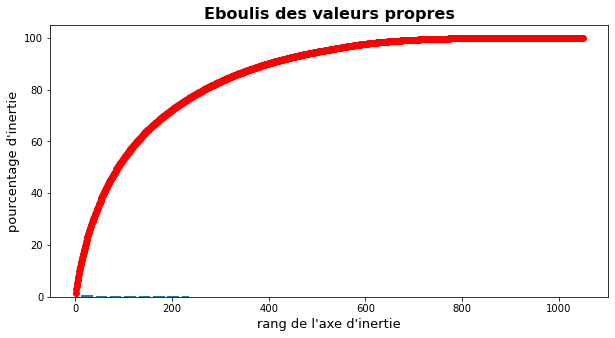

In [71]:
plt.figure(figsize=(10, 5))
display_scree_plot(pca)

Le graphique montre la quantité de variance capturée (sur l'axe des y) en fonction du nombre de composantes que nous incluons (sur l'axe des x). Une règle empirique consiste à préserver environ 80 % de la variance. Il faudrait donc garder 250 composantes.

Nous effectuons l'ACP avec le nombre de composantes choisi ci-dessus.

In [72]:
# ACP
pca = PCA(n_components=250)
pca.fit(cvect_desc_lem_std)

PCA(n_components=250)

Nous n'avons besoin que des scores calculés des composantes résultantes pour les éléments de notre ensemble de données :

In [73]:
pca_cvect_desc_lem = pca.transform(cvect_desc_lem_std)
pca_cvect_desc_lem

array([[ 3.86301673,  5.77408263,  1.09262269, ...,  0.38445344,
         0.08453587,  0.53387555],
       [-0.45298484, -0.12437939,  0.39521515, ...,  0.02097192,
        -0.14824246,  0.87017918],
       [ 3.98486134,  2.05996065,  1.20405698, ..., -0.64855324,
         0.80086551, -0.65289886],
       ...,
       [-1.56805979,  1.81564116, -1.01485319, ...,  1.37370782,
         0.79930955,  1.05996157],
       [-1.91125328, -0.75166736,  0.38867123, ..., -0.20458853,
        -0.06753154, -0.38687563],
       [-1.82663655, -0.32264521,  0.14531793, ...,  0.04763055,
         0.00811413, -0.21760313]])

<div class="alert alert-block alert-warning">
    <p>t-SNE</p>
</div>

L'algorithme t-SNE (t-distributed stochastic neighbor embedding) est une technique de **réduction de dimension** pour la visualisation de données développée par Geoffrey Hinton et Laurens van der Maaten et publiée en 2008. 

Il s'agit d'une **méthode non linéaire permettant de représenter un ensemble de points d'un espace à grande dimension dans un espace de deux ou trois dimensions**. Les données peuvent ensuite être visualisées sous la forme d'un nuage de points. L'algorithme t-SNE tente de trouver une configuration optimale selon un critère de théorie de l'information afin de conserver la proximité entre les points pendant la transformation : deux points qui sont proches (resp. éloignés) dans l'espace d'origine doivent être proches (resp. éloignés) dans l'espace de faible dimension.

Il n'y a pas de règle spécifique pour déterminer les valeurs absolues des hyperparamètres comme la perplexité et le nombre d'itérations, cela dépend du jeu de données. Nous devrons donc exécuter t-SNE à plusieurs reprises avec différentes valeurs d'hyperparamètres avant d'arriver à un graphique approprié pour la visualisation.

<div class="alert alert-block alert-info">
    <p>comprends pas code pour y_cat_num</p>
</div>

In [74]:
# Liste des catégories
categ_list = list(set(data_bow['Cat_0']))
print("catégories : ", categ_list)
y_cat_num = [(1-categ_list.index(data_bow.iloc[i]['Cat_0'])) for i in range(len(data_bow))]

catégories :  ['Baby Care', 'Beauty and Personal Care', 'Watches', 'Home Decor & Festive Needs', 'Computers', 'Home Furnishing', 'Kitchen & Dining']


In [75]:
# Représentation graphique du Tsne
def TSNE_visu(X_tsne, y_cat_num, labels) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=categ_list, loc="best", title="Categorie")
    plt.title('Représentation des produits par catégories')
    
    plt.show()

C:\Users\milie\anaconda3\envs\projet6\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\milie\anaconda3\envs\projet6\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


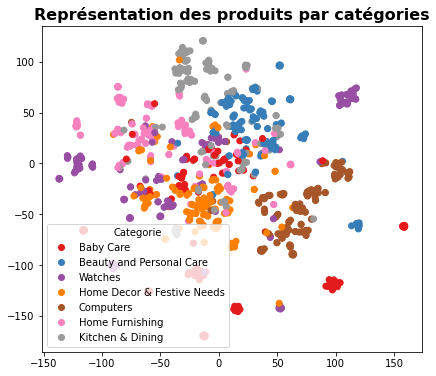

In [76]:
# Avec perplexity = 5 et n_iter = 5000
tsne_5 = manifold.TSNE(n_components=2,
                       perplexity=5,
                       n_iter=5000,
                       random_state=42)

tsne_5_cvect_desc_lem = tsne_5.fit_transform(pca_cvect_desc_lem)

TSNE_visu(tsne_5_cvect_desc_lem, y_cat_num, categ_list)

C:\Users\milie\anaconda3\envs\projet6\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\milie\anaconda3\envs\projet6\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


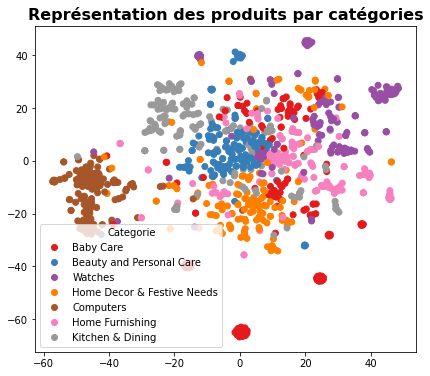

In [77]:
# Avec perplexity = 30 et n_iter = 5000
tsne_30 = manifold.TSNE(n_components=2,
                        perplexity=30,
                        n_iter=5000,
                        random_state=42)

tsne_30_cvect_desc_lem = tsne_30.fit_transform(pca_cvect_desc_lem)

TSNE_visu(tsne_30_cvect_desc_lem, y_cat_num, categ_list)

C:\Users\milie\anaconda3\envs\projet6\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\milie\anaconda3\envs\projet6\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


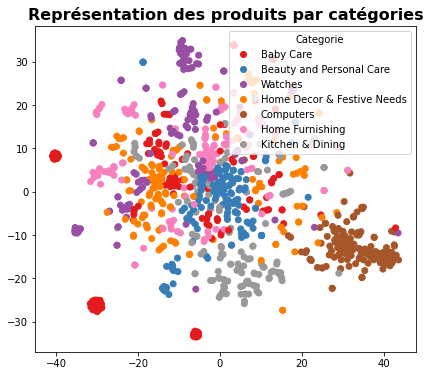

In [78]:
# Avec perplexity = 50 et n_iter = 5000
tsne_50 = manifold.TSNE(n_components=2,
                        perplexity=50,
                        n_iter=5000,
                        random_state=42)

tsne_50_cvect_desc_lem = tsne_50.fit_transform(pca_cvect_desc_lem)

TSNE_visu(tsne_50_cvect_desc_lem, y_cat_num, categ_list)

A la vue des 3 représentations à 2 dimensions, nous allons définir l'hyperparamètre perplexity à 30.

<div class="alert alert-block alert-warning">
    <p>KMeans</p>
</div>

In [79]:
# Initialisation du KMeans avec 7 clusters
kmeans_cvect_desc_lem = KMeans(n_clusters=7, init='k-means++', random_state=42)

In [80]:
# Kmeans sur données issues du t-SNE avec perplexity à 30
kmeans_cvect_desc_lem.fit(tsne_30_cvect_desc_lem)

KMeans(n_clusters=7, random_state=42)

In [81]:
df_cvect_desc_lem_cls = df_cvect_desc_lem.copy()

In [82]:
# Ajout des clusters dans la dataframe original
df_cvect_desc_lem_cls['Clusters'] = kmeans_cvect_desc_lem.labels_

In [83]:
# Création d'une nouvelle colonne avec les clusters sous forme de str
df_cvect_desc_lem_cls['Clusters_str'] = df_cvect_desc_lem_cls['Clusters'].map({
    0: 'Cluster_1',
    1: 'Cluster_2',
    2: 'Cluster_3',
    3: 'Cluster_4',
    4: 'Cluster_5',
    5: 'Cluster_6',
    6: 'Cluster_7'})

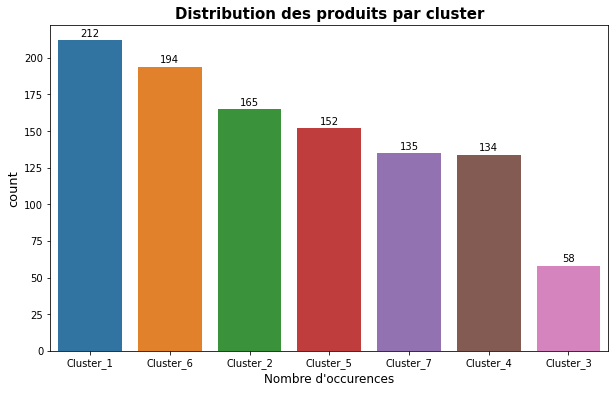

In [84]:
# Distribution des produits par cluster
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Clusters_str', data=df_cvect_desc_lem_cls,
                   order=df_cvect_desc_lem_cls['Clusters_str'].value_counts().index)
plt.title('Distribution des produits par cluster',
          fontweight='bold',
          fontsize=15)
plt.xlabel("Nombre d'occurences", fontsize=12)
etiquette_v(ax, 2)

Nous remarquons qu'avec le countvectorizer sur données lemmatisées, la distribution de nos produits s'éloigne de la distribution originale (150 produits par catégorie).

<div class="alert alert-block alert-warning">
    <p>ARI et représentation graphique</p>
</div>

L'Adjusted Rand Index (ARI) est l'une des métriques les plus utilisées pour valider les performances de clustering.

L'ARI calcule une mesure de similarité entre deux clusters en considérant toutes les paires d'échantillons et en comptant les paires qui sont assignées dans les mêmes ou différents clusters dans les clusters prédits et réels.

L'ARI doit être interprété comme suit :
- ARI >= 0,90 excellente récupération
- 0,80 =< ARI < 0,90 bonne récupération
- 0,65 =< ARI < 0,80 récupération modérée
- ARI < 0,65 mauvaise récupération

In [85]:
# Calcul ARI entre vraies catégories et n° de clusters
def ARI_fct(features) :
    ARI = np.round(adjusted_rand_score(y_cat_num, kmeans_cvect_desc_lem.labels_),4)
    return ARI

In [86]:
ARI_cvect_desc_lem = ARI_fct(kmeans_cvect_desc_lem)

In [87]:
# visualisation du t-SNE selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=categ_list, loc="best", title="Categorie")
    plt.title('Représentation des produits par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des produits par clusters')
    
    plt.show()
    print("ARI : ", ARI)

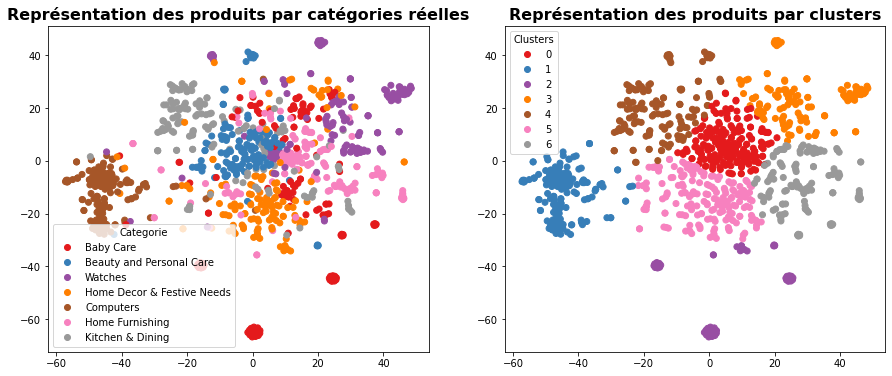

ARI :  0.3245


In [88]:
 TSNE_visu_fct(tsne_30_cvect_desc_lem, y_cat_num, kmeans_cvect_desc_lem.labels_, ARI_cvect_desc_lem)

Nous allons intégrer toutes les étapes précédentes dans une fonction globale qui nous permettra de refaire tourner notre modèle facilement et de récupérer les informations de validation de performance des modèles (durée et ARI):

In [89]:
def ARI_BOW(features) :
    time1 = time.time()
    num_labels=len(categ_list)

    # Standardisation des données
    scaler = StandardScaler()
    features_std = scaler.fit_transform(features)

    # ACP
    pca = PCA(n_components=250)
    X_pca = pca.fit_transform(features_std)

    # t-SNE
    tsne = manifold.TSNE(n_components=2,
                         perplexity=50,
                         n_iter=5000,
                         random_state=42)
    X_tsne = tsne.fit_transform(X_pca)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = KMeans(n_clusters=7,
                 init='k-means++',
                 random_state=42)
    cls.fit(X_tsne)
    
    # Ajout des clusters dans la dataframe original
    features['Clusters'] = cls.labels_
    
    # Distribution des produits par cluster
    plt.figure(figsize=(8, 4))
    ax = sns.countplot(x='Clusters',
                       data=features,
                       order=features['Clusters'].value_counts().index)
    plt.title('Distribution des produits par cluster',
              fontweight='bold',fontsize=15)
    plt.xlabel("Nombre d'occurences", fontsize=12)
    etiquette_v(ax, 2)
    
    ARI = np.round(adjusted_rand_score(y_cat_num, cls.labels_),4)
    
    time2 = np.round(time.time() - time1,0)
    
    return ARI, X_tsne, cls.labels_, time2

C:\Users\milie\anaconda3\envs\projet6\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\milie\anaconda3\envs\projet6\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


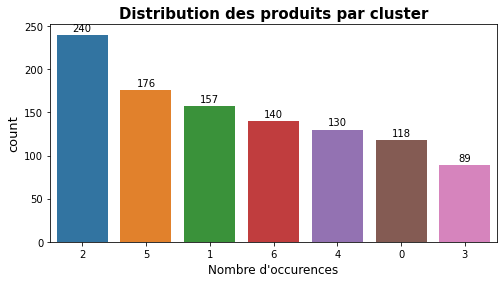

In [90]:
ARI_cvect_desc_lem, X_tsne_cvect_desc_lem, labels_cvect_desc_lem, time2_cvect_desc_lem = ARI_BOW(df_cvect_desc_lem)

In [91]:
df_cvect_desc_lem_recap = {'Modèle':['Countvectorizer'],
                           'Preprocessing':['Lemmatization'],
                           '.fit':['desc_clean_lem'],
                           '.transform':['pname_desc_clean_lem'],
                           'ARI':[ARI_cvect_desc_lem], 
                           "Temps d'entrainement": [time2_cvect_desc_lem],}
df_cvect_desc_lem_recap = pd.DataFrame(data = df_cvect_desc_lem_recap)

In [92]:
df_cvect_desc_lem_recap

,Modèle,Preprocessing,.fit,.transform,ARI,Temps d'entrainement
0,Countvectorizer,Lemmatization,desc_clean_lem,pname_desc_clean_lem,0.2846,26.0


##### Countvectorizer sur données lemmatisées avec extraction des features de la colonne product_name (pname_clean_lem)

In [93]:
df_cvect_pname_lem = bag_of_word(data_bow,
                                 'pname_clean_lem',
                                 'pname_clean_lem',
                                 'pname_desc_clean_lem',
                                 CountVectorizer())

C:\Users\milie\anaconda3\envs\projet6\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\milie\anaconda3\envs\projet6\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


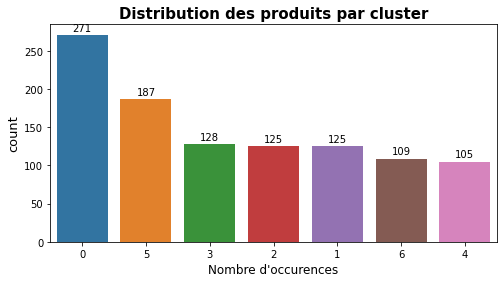

In [94]:
ARI_cvect_pname_lem, X_tsne_cvect_pname_lem, labels_cvect_pname_lem, time2_cvect_pname_lem = ARI_BOW(df_cvect_pname_lem)

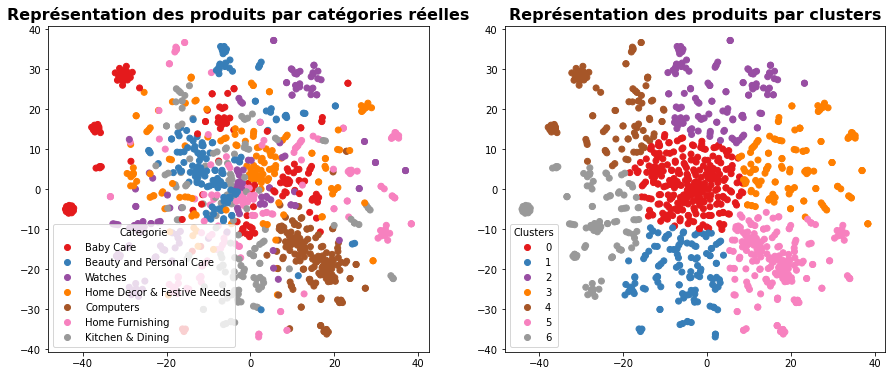

ARI :  0.2114


In [95]:
 TSNE_visu_fct(X_tsne_cvect_pname_lem,
               y_cat_num,
               labels_cvect_pname_lem,
               ARI_cvect_pname_lem)

In [96]:
df_cvect_pname_lem_recap = {'Modèle':['Countvectorizer'],
                            'Preprocessing':['Lemmatization'],
                            '.fit':['pname_clean_lem'],
                            '.transform':['pname_desc_clean_lem'],
                            'ARI':[ARI_cvect_pname_lem], 
                            "Temps d'entrainement": [time2_cvect_pname_lem],}
df_cvect_pname_lem_recap = pd.DataFrame(data = df_cvect_pname_lem_recap)

In [97]:
df_models = pd.concat([df_cvect_desc_lem_recap, df_cvect_pname_lem_recap]).reset_index(drop = True)
df_models

,Modèle,Preprocessing,.fit,.transform,ARI,Temps d'entrainement
0,Countvectorizer,Lemmatization,desc_clean_lem,pname_desc_clean_lem,0.2846,26.0
1,Countvectorizer,Lemmatization,pname_clean_lem,pname_desc_clean_lem,0.2114,36.0


##### Countvectorizer sur données lemmatisées avec extraction des features de la colonne product_name + description (pname_desc_clean_lem)

In [98]:
df_cvect_pnamedesc_lem = bag_of_word(data_bow,
                                     'pname_clean_lem',
                                     'pname_desc_clean_lem',
                                     'pname_desc_clean_lem',
                                     CountVectorizer())

C:\Users\milie\anaconda3\envs\projet6\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\milie\anaconda3\envs\projet6\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


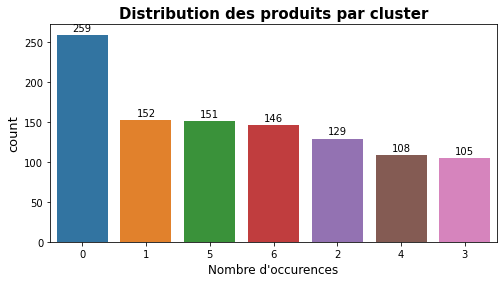

In [99]:
ARI_cvect_pnamedesc_lem, X_tsne_cvect_pnamedesc_lem, labels_cvect_pnamedesc_lem, time2_cvect_pnamedesc_lem = ARI_BOW(df_cvect_pnamedesc_lem)

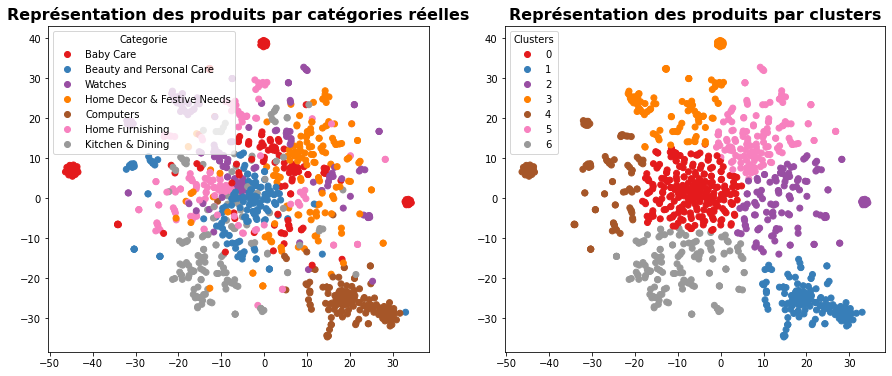

ARI :  0.2666


In [100]:
TSNE_visu_fct(X_tsne_cvect_pnamedesc_lem,
              y_cat_num,
              labels_cvect_pnamedesc_lem,
              ARI_cvect_pnamedesc_lem)

In [101]:
df_cvect_pnamedesc_lem_recap = {'Modèle':['Countvectorizer'],
                                'Preprocessing':['Lemmatization'],
                               '.fit':['pname_desc_clean_lem'],
                               '.transform':['pname_desc_clean_lem'],
                               'ARI':[ARI_cvect_pnamedesc_lem], 
                               "Temps d'entrainement": [time2_cvect_pnamedesc_lem],}
df_cvect_pnamedesc_lem_recap = pd.DataFrame(data = df_cvect_pnamedesc_lem_recap)

In [102]:
df_models = pd.concat([df_models, df_cvect_pnamedesc_lem_recap]).reset_index(drop = True)
df_models

,Modèle,Preprocessing,.fit,.transform,ARI,Temps d'entrainement
0,Countvectorizer,Lemmatization,desc_clean_lem,pname_desc_clean_lem,0.2846,26.0
1,Countvectorizer,Lemmatization,pname_clean_lem,pname_desc_clean_lem,0.2114,36.0
2,Countvectorizer,Lemmatization,pname_desc_clean_lem,pname_desc_clean_lem,0.2666,22.0


##### Countvectorizer sur données non lemmatisées avec extraction des features de la colonne product_name + description (pname_desc_clean)

Nous allons cette fois ci appliquer le Countvectorizer sur les données non lemmatisées avec extraction des features de la colonne product_name + description (pname_desc_clean). Nous créons la variable pname_desc_clean qui sera la concaténation des features pname_clean et desc_clean.

In [103]:
data_bow["pname_desc_clean"] = \
    data_bow["pname_clean"] + " " + data_bow["desc_clean"]

In [104]:
df_cvect_pnamedesc = bag_of_word(data_bow,
                                 'pname_clean',
                                 'pname_desc_clean',
                                 'pname_desc_clean',
                                 CountVectorizer())

C:\Users\milie\anaconda3\envs\projet6\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\milie\anaconda3\envs\projet6\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


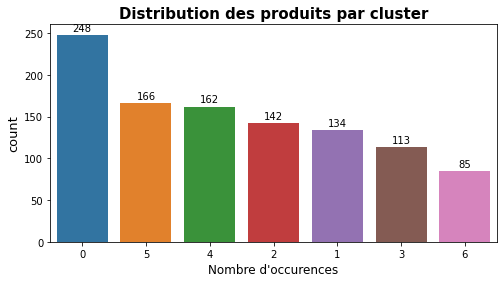

In [105]:
ARI_cvect_pnamedesc, X_tsne_cvect_pnamedesc, labels_cvect_pnamedesc, time2_cvect_pnamedesc = ARI_BOW(df_cvect_pnamedesc)

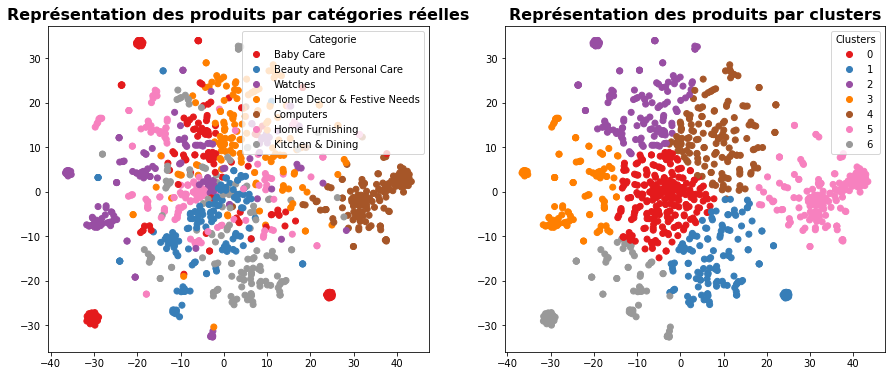

ARI :  0.2771


In [106]:
 TSNE_visu_fct(X_tsne_cvect_pnamedesc,
               y_cat_num,
               labels_cvect_pnamedesc,
               ARI_cvect_pnamedesc)

In [107]:
df_cvect_pnamedesc_recap = {'Modèle':['Countvectorizer'],
                            'Preprocessing':['No Lemmatization'],
                            '.fit':['pname_desc_clean'],
                            '.transform':['pname_desc_clean'],
                            'ARI':[ARI_cvect_pnamedesc], 
                            "Temps d'entrainement": [time2_cvect_pnamedesc],}
df_cvect_pnamedesc_recap = pd.DataFrame(data = df_cvect_pnamedesc_recap)

In [108]:
df_models = pd.concat([df_models, df_cvect_pnamedesc_recap]).reset_index(drop = True)
df_models

,Modèle,Preprocessing,.fit,.transform,ARI,Temps d'entrainement
0,Countvectorizer,Lemmatization,desc_clean_lem,pname_desc_clean_lem,0.2846,26.0
1,Countvectorizer,Lemmatization,pname_clean_lem,pname_desc_clean_lem,0.2114,36.0
2,Countvectorizer,Lemmatization,pname_desc_clean_lem,pname_desc_clean_lem,0.2666,22.0
3,Countvectorizer,No Lemmatization,pname_desc_clean,pname_desc_clean,0.2771,32.0


En analysant le score ARI et le temps d'entrainement de nos différents modèles, le plus performant de la catégorie Countvectorizer est notre modèle où:
- les données ont été lemmatisées
- l'extraction du vocabulaire a été faite sur la colonne product_name + description (pname_desc_clean_lem)
- et la vectorisation faite sur la colonne pname_desc_clean_lem

#### Tf-idf <a class="anchor" id="tf"></a>

Le **Countvectorizer** utilise les fréquences d'apparition des différents mots/n-grammes présents dans notre **corpus**. Le problème est que si l'on veut vraiment représenter un document par les **n-grammes** qu'il contient, il faudrait le faire relativement à leur **apparition dans les autres documents**.

**En effet, si un mot apparait dans d'autres documents, il est donc moins représentatif du document qu'un mot qui n'apparait que uniquement dans ce document.**

Nous avons d'abord supprimé les mots les plus fréquents de manière générale dans le langage (les fameux stopwords). À présent, il ne faut pas considérer le poids d'un mot dans un document comme sa fréquence d'apparition uniquement, mais **pondérer** cette fréquence par un indicateur si ce **mot est commun ou rare dans tous les documents**.

Pour résumer, le poids du n-gramme est le suivant :
poids = fréquence du terme × indicateur similarité

En l’occurence, la métrique tf-idf (Term-Frequency - Inverse Document Frequency) utilise comme indicateur de similarité l'inverse document frequency qui est l'inverse de la proportion de document qui contient le terme, à l'échelle logarithmique. Il est appelé logiquement « inverse document frequency » (idf). 

Nous calculons donc le poids tf-idf final attribué au n-gramme :
poids=frequence du n-gram × idf(n-gramme)

##### Tf-idf sur données lemmatisées avec extraction des features de la colonne product_name + description (pname_desc_clean_lem)

In [109]:
df_tfidf_pdesc_lem = bag_of_word(data_bow,
                                 'pname_clean',
                                 'pname_desc_clean_lem',
                                 'pname_desc_clean_lem',
                                 TfidfVectorizer())

C:\Users\milie\anaconda3\envs\projet6\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\milie\anaconda3\envs\projet6\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


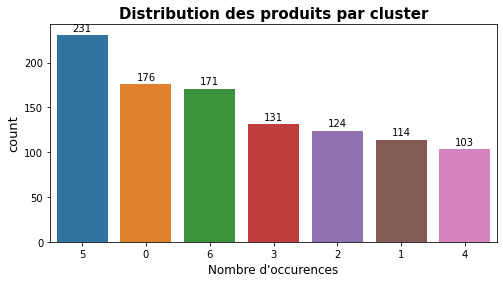

In [110]:
ARI_tfidf_pdesc_lem, X_tsne_tfidf_pdesc_lem, labels_tfidf_pdesc_lem, time2_tfidf_pdesc_lem = ARI_BOW(df_tfidf_pdesc_lem)

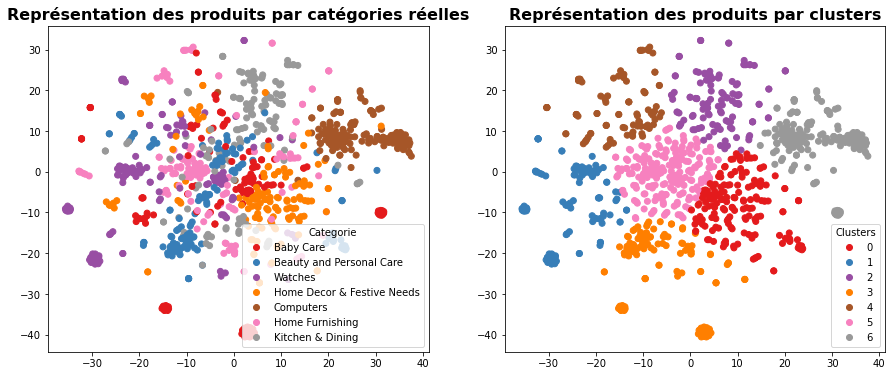

ARI :  0.2665


In [111]:
 TSNE_visu_fct(X_tsne_tfidf_pdesc_lem,
               y_cat_num,
               labels_tfidf_pdesc_lem,
               ARI_tfidf_pdesc_lem)

In [112]:
df_tfidf_pdesc_lem_recap = {'Modèle':['Tf-idf'],
                           'Preprocessing':['Lemmatization'],
                           '.fit':['pname_desc_clean_lem'],
                           '.transform':['pname_desc_clean_lem'],
                           'ARI':[ARI_tfidf_pdesc_lem], 
                           "Temps d'entrainement": [time2_tfidf_pdesc_lem],}
df_tfidf_pdesc_lem_recap = pd.DataFrame(data = df_tfidf_pdesc_lem_recap)

In [113]:
df_models = pd.concat([df_models, df_tfidf_pdesc_lem_recap]).reset_index(drop = True)
df_models

,Modèle,Preprocessing,.fit,.transform,ARI,Temps d'entrainement
0,Countvectorizer,Lemmatization,desc_clean_lem,pname_desc_clean_lem,0.2846,26.0
1,Countvectorizer,Lemmatization,pname_clean_lem,pname_desc_clean_lem,0.2114,36.0
2,Countvectorizer,Lemmatization,pname_desc_clean_lem,pname_desc_clean_lem,0.2666,22.0
3,Countvectorizer,No Lemmatization,pname_desc_clean,pname_desc_clean,0.2771,32.0
4,Tf-idf,Lemmatization,pname_desc_clean_lem,pname_desc_clean_lem,0.2665,25.0


##### Tf-idf sur données non lemmatisées avec extraction des features de la colonne product_name + description (pname_desc_clean)

In [114]:
df_tfidf_pdesc = bag_of_word(data_bow,
                             'pname_clean',
                             'pname_desc_clean',
                             'pname_desc_clean',
                             TfidfVectorizer())

C:\Users\milie\anaconda3\envs\projet6\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\milie\anaconda3\envs\projet6\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


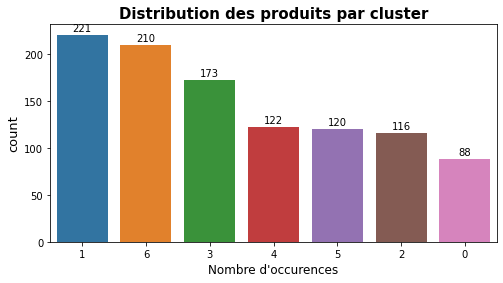

In [115]:
ARI_tfidf_pdesc, X_tsne_tfidf_pdesc, labels_tfidf_pdesc, time2_tfidf_pdesc = ARI_BOW(df_tfidf_pdesc)

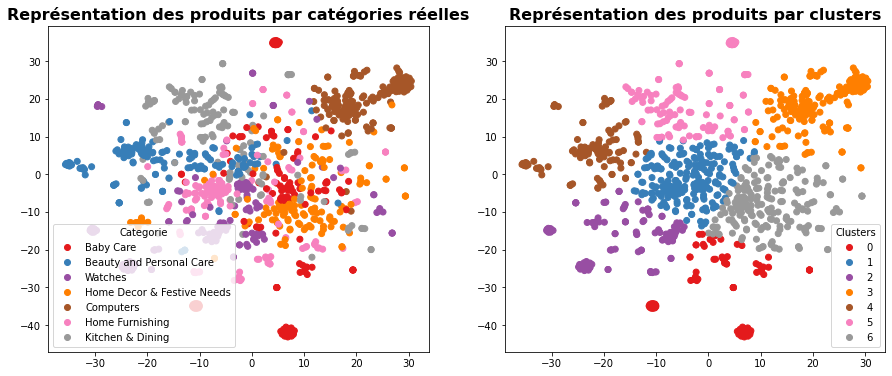

ARI :  0.3061


In [116]:
 TSNE_visu_fct(X_tsne_tfidf_pdesc,
               y_cat_num,
               labels_tfidf_pdesc,
               ARI_tfidf_pdesc)

In [117]:
df_tfidf_pdesc_recap = {'Modèle':['Tf-idf'],
                       'Preprocessing':['No Lemmatization'],
                       '.fit':['pname_desc_clean'],
                       '.transform':['pname_desc_clean'],
                       'ARI':[ARI_tfidf_pdesc], 
                       "Temps d'entrainement": [time2_tfidf_pdesc],}
df_tfidf_pdesc_recap = pd.DataFrame(data = df_tfidf_pdesc_recap)

In [118]:
df_models = pd.concat([df_models, df_tfidf_pdesc_recap]).reset_index(drop = True)
df_models

,Modèle,Preprocessing,.fit,.transform,ARI,Temps d'entrainement
0,Countvectorizer,Lemmatization,desc_clean_lem,pname_desc_clean_lem,0.2846,26.0
1,Countvectorizer,Lemmatization,pname_clean_lem,pname_desc_clean_lem,0.2114,36.0
2,Countvectorizer,Lemmatization,pname_desc_clean_lem,pname_desc_clean_lem,0.2666,22.0
3,Countvectorizer,No Lemmatization,pname_desc_clean,pname_desc_clean,0.2771,32.0
4,Tf-idf,Lemmatization,pname_desc_clean_lem,pname_desc_clean_lem,0.2665,25.0
5,Tf-idf,No Lemmatization,pname_desc_clean,pname_desc_clean,0.3061,24.0


Avec les méthodes de comptage évoquées, nous créons en réalité des **« matrices creuses »**. En effet, les mots ne sont pas présents dans chaque document (le ratio vocabulaire / taille de document est trop élevé). De plus, on utilise plus souvent certains mots (“et”, “le”, etc.) et d’autres plus rarement (dans des contextes précis).

Cette grosse différence créé des matrices larges (de la taille « nombre de documents * taille du vocabulaire ») qui sont essentiellement vides. On verra qu’on peut utiliser ces matrices avec un certain nombre d’algorithmes, mais c’est tout de même un **gaspillage non négligeable de ressources que de travailler avec des matrices de cette taille alors que la plupart des entrées ne sont pas informatives**.

De plus, les matrices creuses peuvent **biaiser les algorithmes qui considèrent ainsi que les observations à zéro (qui sont présentes en majorité) représente une information à prendre en considération**. Si on pense en terme de moyenne par exemple, elle sera écrasée par la présence de toute ces entrées vides sans pour autant apporter plus de sens à notre calcul.

### Approches de type word/sentence embedding classique <a class="anchor" id="wse"></a>

On appelle la technique de représentation d’un mot, ou un ensemble de mots en vecteurs de dimension inférieure, word embeddings, soit littéralement « plongement de mot ».

Une récente famille de techniques (circa 2013) a permi de repenser ce modèle avec une **représentation des mots dans un espace avec une forme de similarité entre eux** (c'est-à-dire probabiliste), dans lesquels le sens des mots les rapproche dans cet espace, en terme de distances statistiques. C’est un plongement dans un espace de dimension inférieur autour de 20-100 dimensions généralement. Son petit nom : word2vec.

Effectivement. L’hypothèse principale de ces méthodes étant de **prendre en compte le “contexte”** dans lequel le mot a été trouvé, c’est à dire les mots avec lesquels il est souvent utilisé. On appelle cette hypothèse distributional hypothesis.

Et ce qui est intéressant, c’est que ce contexte permet de créer un espace qui rapproche des mots qui ne se sont pas forcément trouvés à côté les uns des autres dans un corpus.

Afin de calculer les vecteurs qui représentent les mots, les méthodes word2vec utilisent des **perceptrons linéaires simples avec une seule couche cachée**. L’idée est de compresser notre corpus vers un dictionnaire de vecteurs denses de dimension bien inférieure choisie.

On ne va pas détailler les méthodes d’entraînement en détails, mais il faut savoir qu’il en existe deux principales. La première appelée « Continuous Bag of Words » (CBOW), qui entraîne le réseau de neurones pour prédire un mot en fonction de son contexte, c’est à dire les mots avant/après dans une phrase. Dans la seconde méthode, on essaie de prédire le contexte en fonction du mot. C’est la technique du « skip-gram ».

#### Word2Vec <a class="anchor" id="w2v"></a>

##### Word2Vec sur données lemmatisées avec extraction des features de la colonne product_name + description (pname_desc_clean_lem)

<div class="alert alert-block alert-warning">
    <p>Création et entrainement du modèle </p>
</div>

In [119]:
# Choix des hyperparamètres
# Dimensionnalité des vecteurs de mots
size=300
# Distance maximale entre le mot actuel et le mot prédit dans une phrase
window=5
# Ignore tous les mots dont la fréquence totale est inférieure à cette valeur
min_count=1
# Nombre d'itérations à travers le corpus
epochs=100
# Reproductibilité des résultats
seed=42
maxlen = 24 # adapt to length of sentences

In [120]:
# Liste de liste de tokens
list_tokens = data_bow['pname_desc_clean_lem'].to_list()
list_tokens = [gensim.utils.simple_preprocess(text) for text in list_tokens]

In [121]:
# Initialisation
w2v_desc_lem = gensim.models.Word2Vec(min_count=min_count,
                                      window=window,
                                      vector_size=size,
                                      seed=seed,
                                      workers=1)

In [122]:
# Construction du vocabulaire à partir d'une séquence de mots
w2v_desc_lem.build_vocab(list_tokens)

In [123]:
# Entrainement du modèle
w2v_desc_lem.train(list_tokens,
                   total_examples=w2v_desc_lem.corpus_count,
                   epochs=epochs)

(4462181, 4982400)

In [124]:
# Vectorisation
vectors_w2v_desc_lem = w2v_desc_lem.wv

In [125]:
w2v_words = vectors_w2v_desc_lem.index_to_key
print("Vocabulary size: %i" % len(w2v_words))

Vocabulary size: 3151


<div class="alert alert-block alert-warning">
    <p>Tokenization</p>
</div>

In [126]:
print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list_tokens)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(list_tokens),
                            maxlen=maxlen,
                            padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 3152


<div class="alert alert-block alert-warning">
    <p>Création de la matrice d'embedding</p>
</div>

In [127]:
print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = vectors_w2v_desc_lem[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = vectors_w2v_desc_lem[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (3152, 300)


<div class="alert alert-block alert-warning">
    <p>Création du modèle d'embedding</p>
</div>

In [128]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding (Embedding)       (None, 24, 300)           945600    
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 945,600
Trainable params: 945,600
Non-trainable params: 0
_________________________________________________________________


<div class="alert alert-block alert-warning">
    <p>Exécution du modèle</p>
</div>

In [129]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 0s 2ms/step


(1050, 300)

<div class="alert alert-block alert-warning">
    <p>Fonction globale pour Word2Vec</p>
</div>

In [130]:
def W2v(df, col_vocab, vector_size, window, min_count, epochs, maxlen):
    
    # Liste de liste de tokens
    list_tokens = df[col_vocab].to_list()
    list_tokens = [gensim.utils.simple_preprocess(text) for text in list_tokens]
    
    # Initialisation
    mod_w2v = gensim.models.Word2Vec(min_count=min_count,
                                     window=window,
                                     vector_size=vector_size,
                                     seed=42,
                                     workers=1)
    
    # Construction du vocabulaire à partir d'une séquence de mots
    mod_w2v.build_vocab(list_tokens)
    
    # Entrainement du modèle
    mod_w2v.train(list_tokens,
                  total_examples=mod_w2v.corpus_count,
                  epochs=epochs)
    
    # Vectorisation
    vectors_mod_w2v = mod_w2v.wv
    w2v_words = vectors_mod_w2v.index_to_key
    print("Vocabulary size: %i" % len(w2v_words))
    
    # Tokenization (transforme liste de tokens en séquence de mot)
    print("Fit Tokenizer ...")
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(list_tokens)
    x_sentences = pad_sequences(tokenizer.texts_to_sequences(list_tokens),
                                maxlen=maxlen,
                                padding='post') 
                                                   
    num_words = len(tokenizer.word_index) + 1
    print("Number of unique words: %i" % num_words)
    
    # Embedding matrix
    print("Create Embedding matrix ...")
    w2v_size = vector_size
    word_index = tokenizer.word_index
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, w2v_size))
    i=0
    j=0
    
    for word, idx in word_index.items():
        i +=1
        if word in w2v_words:
            j +=1
            embedding_vector = vectors_mod_w2v[word]
            if embedding_vector is not None:
                embedding_matrix[idx] = vectors_mod_w2v[word]
            
    word_rate = np.round(j/i,4)
    print("Word embedding rate : ", word_rate)
    print("Embedding matrix: %s" % str(embedding_matrix.shape))
    
    # Création du modèle
    input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
    word_input=Input(shape=(maxlen,),dtype='float64')  
    word_embedding=Embedding(input_dim=vocab_size,
                             output_dim=w2v_size,
                             weights = [embedding_matrix],
                             input_length=maxlen)(word_input)
    word_vec=GlobalAveragePooling1D()(word_embedding)  
    embed_model = Model([word_input],word_vec)
    
    # Exécution du modèle
    embeddings = embed_model.predict(x_sentences)
    embeddings.shape
    
    return embeddings

In [131]:
embeddings_w2v_pdesc_lem = W2v(df = data_bow,
                               col_vocab = 'pname_desc_clean_lem',
                               vector_size=300,
                               window=5,
                               min_count=1,
                               epochs=100,
                               maxlen = 24)

Vocabulary size: 3151
Fit Tokenizer ...
Number of unique words: 3152
Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (3152, 300)
33/33 [==============================] - 0s 2ms/step


In [132]:
def ARI_CBOW(features) :
    time1 = time.time()

    # t-SNE
    tsne = manifold.TSNE(n_components=2,
                         perplexity=50,
                         n_iter=5000,
                         random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = KMeans(n_clusters=7,
                 init='k-means++',
                 random_state=42)
    cls.fit(X_tsne)
    
    ARI = np.round(adjusted_rand_score(y_cat_num, cls.labels_),4)
    
    time2 = np.round(time.time() - time1,0)
    
    return ARI, X_tsne, cls.labels_, time2

In [133]:
ARI_w2v_pdesc_lem, X_tsne_w2v_pdesc_lem, labels_w2v_pdesc_lem, time2_w2v_pdesc_lem = ARI_CBOW(embeddings_w2v_pdesc_lem)

C:\Users\milie\anaconda3\envs\projet6\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\milie\anaconda3\envs\projet6\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


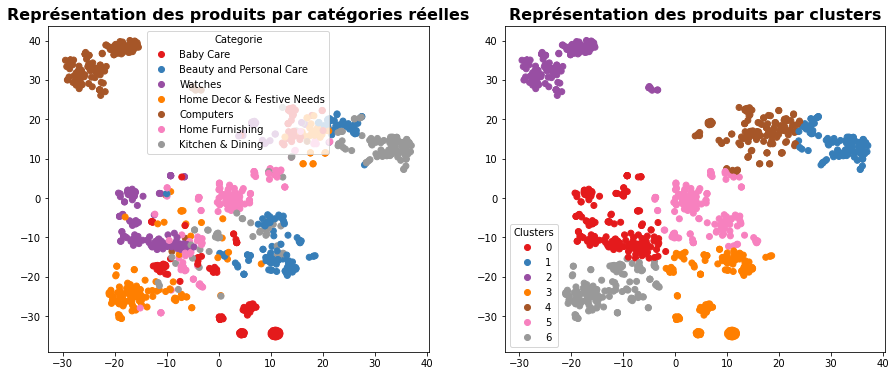

ARI :  0.4189


In [134]:
TSNE_visu_fct(X_tsne_w2v_pdesc_lem,
              y_cat_num,
              labels_w2v_pdesc_lem,
              ARI_w2v_pdesc_lem)

In [135]:
df_w2v_pdesc_lem_recap = {'Modèle':['Word2Vec'],
                           'Preprocessing':['Lemmatization'],
                         '.fit':['pname_desc_clean_lem'],
                          '.transform':['pname_desc_clean_lem'],
                          'ARI':[ARI_w2v_pdesc_lem], 
                          "Temps d'entrainement": [time2_w2v_pdesc_lem],}
df_w2v_pdesc_lem_recap = pd.DataFrame(data = df_w2v_pdesc_lem_recap)

In [136]:
df_models = pd.concat([df_models, df_w2v_pdesc_lem_recap]).reset_index(drop = True)
df_models

,Modèle,Preprocessing,.fit,.transform,ARI,Temps d'entrainement
0,Countvectorizer,Lemmatization,desc_clean_lem,pname_desc_clean_lem,0.2846,26.0
1,Countvectorizer,Lemmatization,pname_clean_lem,pname_desc_clean_lem,0.2114,36.0
2,Countvectorizer,Lemmatization,pname_desc_clean_lem,pname_desc_clean_lem,0.2666,22.0
3,Countvectorizer,No Lemmatization,pname_desc_clean,pname_desc_clean,0.2771,32.0
4,Tf-idf,Lemmatization,pname_desc_clean_lem,pname_desc_clean_lem,0.2665,25.0
5,Tf-idf,No Lemmatization,pname_desc_clean,pname_desc_clean,0.3061,24.0
6,Word2Vec,Lemmatization,pname_desc_clean_lem,pname_desc_clean_lem,0.4189,14.0


##### Word2Vec sur données non lemmatisées avec extraction des features de la colonne product_name + description (pname_desc_clean)

In [137]:
embeddings_w2v_pdesc = W2v(df = data_bow,
                           col_vocab = 'pname_desc_clean',
                           vector_size=300,
                           window=5,
                           min_count=1,
                           epochs=100,
                           maxlen = 24)

Vocabulary size: 3425
Fit Tokenizer ...
Number of unique words: 3426
Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (3426, 300)
33/33 [==============================] - 0s 2ms/step


In [138]:
ARI_w2v_pdesc, X_tsne_w2v_pdesc, labels_w2v_pdesc, time2_w2v_pdesc = ARI_CBOW(embeddings_w2v_pdesc)

C:\Users\milie\anaconda3\envs\projet6\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\milie\anaconda3\envs\projet6\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


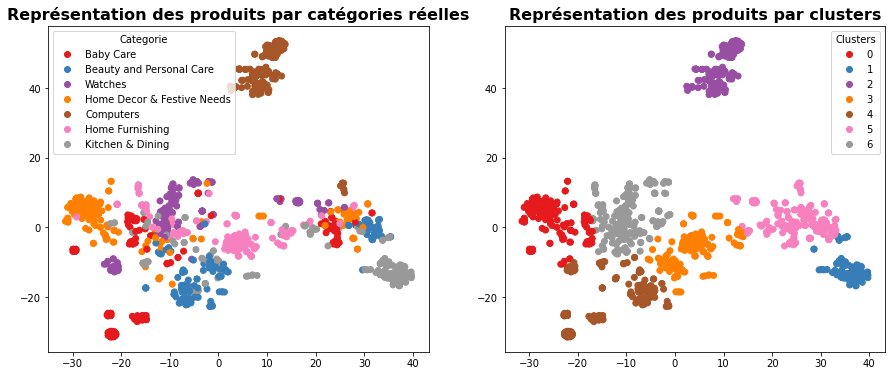

ARI :  0.3389


In [139]:
TSNE_visu_fct(X_tsne_w2v_pdesc,
              y_cat_num,
              labels_w2v_pdesc,
              ARI_w2v_pdesc)

In [140]:
df_w2v_pdesc_recap = {'Modèle':['Word2Vec'],
                      'Preprocessing':['No Lemmatization'],
                      '.fit':['pname_desc_clean'],
                      '.transform':['pname_desc_clean'],
                      'ARI':[ARI_w2v_pdesc], 
                      "Temps d'entrainement": [time2_w2v_pdesc],}
df_w2v_pdesc_recap = pd.DataFrame(data = df_w2v_pdesc_recap)

In [141]:
df_models = pd.concat([df_models, df_w2v_pdesc_recap]).reset_index(drop = True)
df_models

,Modèle,Preprocessing,.fit,.transform,ARI,Temps d'entrainement
0,Countvectorizer,Lemmatization,desc_clean_lem,pname_desc_clean_lem,0.2846,26.0
1,Countvectorizer,Lemmatization,pname_clean_lem,pname_desc_clean_lem,0.2114,36.0
2,Countvectorizer,Lemmatization,pname_desc_clean_lem,pname_desc_clean_lem,0.2666,22.0
3,Countvectorizer,No Lemmatization,pname_desc_clean,pname_desc_clean,0.2771,32.0
4,Tf-idf,Lemmatization,pname_desc_clean_lem,pname_desc_clean_lem,0.2665,25.0
5,Tf-idf,No Lemmatization,pname_desc_clean,pname_desc_clean,0.3061,24.0
6,Word2Vec,Lemmatization,pname_desc_clean_lem,pname_desc_clean_lem,0.4189,14.0
7,Word2Vec,No Lemmatization,pname_desc_clean,pname_desc_clean,0.3389,14.0


##### Word2Vec sur données lemmatisées avec extraction des features de la colonne product_name + description (pname_desc_clean) et hyperparamètre size = 600

In [142]:
embeddings_w2v_pdesc_lem600 = W2v(df = data_bow,
                                  col_vocab = 'pname_desc_clean_lem',
                                  vector_size=600,
                                  window=5,
                                  min_count=1,
                                  epochs=100,
                                  maxlen = 24)

Vocabulary size: 3151
Fit Tokenizer ...
Number of unique words: 3152
Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (3152, 600)
33/33 [==============================] - 0s 2ms/step


In [143]:
ARI_w2v_pdesc_lem600, X_tsne_w2v_pdesc_lem600, labels_w2v_pdesc_lem600, time2_w2v_pdesc_lem600 = ARI_CBOW(embeddings_w2v_pdesc_lem600)

C:\Users\milie\anaconda3\envs\projet6\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\milie\anaconda3\envs\projet6\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


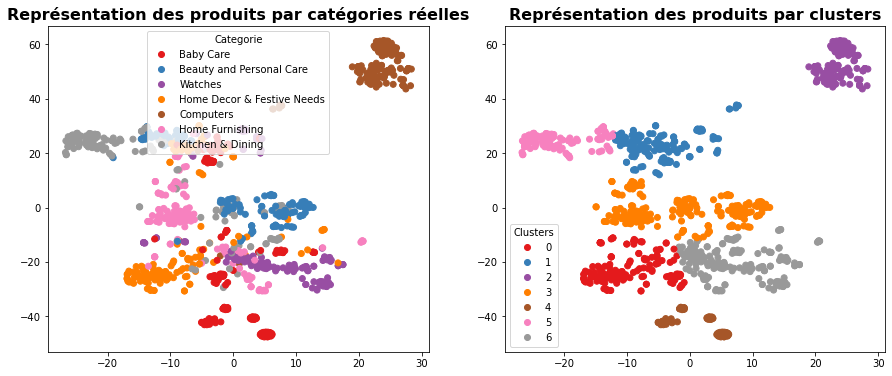

ARI :  0.3812


In [144]:
TSNE_visu_fct(X_tsne_w2v_pdesc_lem600,
              y_cat_num,
              labels_w2v_pdesc_lem600,
              ARI_w2v_pdesc_lem600)

In [145]:
df_w2v_pdesc_lem600_recap = {'Modèle':['Word2Vec size=600'],
                             'Preprocessing':['Lemmatization'],
                            '.fit':['pname_desc_clean_lem'],
                            '.transform':['pname_desc_clean_lem'],
                            'ARI':[ARI_w2v_pdesc_lem600], 
                            "Temps d'entrainement": [time2_w2v_pdesc_lem600],}
df_w2v_pdesc_lem600_recap = pd.DataFrame(data = df_w2v_pdesc_lem600_recap)

In [146]:
df_models = pd.concat([df_models, df_w2v_pdesc_lem600_recap]).reset_index(drop = True)
df_models

,Modèle,Preprocessing,.fit,.transform,ARI,Temps d'entrainement
0,Countvectorizer,Lemmatization,desc_clean_lem,pname_desc_clean_lem,0.2846,26.0
1,Countvectorizer,Lemmatization,pname_clean_lem,pname_desc_clean_lem,0.2114,36.0
2,Countvectorizer,Lemmatization,pname_desc_clean_lem,pname_desc_clean_lem,0.2666,22.0
3,Countvectorizer,No Lemmatization,pname_desc_clean,pname_desc_clean,0.2771,32.0
4,Tf-idf,Lemmatization,pname_desc_clean_lem,pname_desc_clean_lem,0.2665,25.0
5,Tf-idf,No Lemmatization,pname_desc_clean,pname_desc_clean,0.3061,24.0
6,Word2Vec,Lemmatization,pname_desc_clean_lem,pname_desc_clean_lem,0.4189,14.0
7,Word2Vec,No Lemmatization,pname_desc_clean,pname_desc_clean,0.3389,14.0
8,Word2Vec size=600,Lemmatization,pname_desc_clean_lem,pname_desc_clean_lem,0.3812,24.0


### Approches de type word/sentence embedding avec BERT <a class="anchor" id="bert"></a>

En octobre 2018 la filière d’intelligence artificielle de Google (Google AI) a publié un modèle de deep learning pré-entraîné, appelé BERT, capable de résoudre plusieurs problématiques de NLP.

Pour une grande partie des tâches de NLP, Bert offre les **meilleurs résultats actuellement**. Google a même avancé que ce modèle dépassait les performances humaines sur certaines tâches, ce qui est une grande étape pour tout algorithme de Machine Learning.

BERT est un modèle de transformer pré-entraîné sur un **large corpus de données anglaises de manière auto-supervisée**. Cela signifie qu'il a été pré-entraîné sur les textes bruts uniquement, sans qu'aucun humain ne les étiquete de quelque manière que ce soit avec un processus automatique pour générer des entrées et des étiquettes à partir de ces textes. Plus précisément, il a été pré-entraîné avec deux objectifs :
- La **modélisation du langage masqué** (MLM) : en prenant une phrase, le modèle **masque aléatoirement 15 % des mots en entrée**, puis fait passer toute la phrase masquée par le modèle et doit prédire les mots masqués. Cette méthode est différente des réseaux neuronaux récurrents traditionnels (RNN) qui voient généralement les mots les uns après les autres, ou des modèles autorégressifs comme GPT qui masque en interne les futurs tokens. Cela permet au modèle d'apprendre une **représentation bidirectionnelle de la phrase**.
- **Prédiction de la phrase suivante (NSP)** : le modèle **concatène deux phrases masquées en entrée lors du pré-entraînement**. Parfois, elles correspondent à des phrases qui étaient voisines dans le texte original, parfois non. Le modèle doit alors **prédire si les deux phrases se suivent ou non**.

BERT est un modèle de représentation du langage très puissant qui a marqué une étape importante dans le domaine du traitement automatique du langage – il a considérablement augmenté notre capacité à faire de l’apprentissage par transfert en NLP. Bert permettra par exemple de classifier les tweets selon le sentiment qu’ils renvoient ou encore de créer un assistant virtuel capable de répondre aux questions de façon intelligente. 

### BERT HuggingFace (modèle de base uncased) <a class="anchor" id="bert_hugging"></a>

Il s'agit d'un modèle pré entrainé sur la langue anglaise qui ne fait pas la différence sur la casse des mots.

In [147]:
# Fusion des variables product_name et description
data_bow["pname_desc_clean_bert_use"] = \
    data_bow["product_name"] + " " + data_bow["description"]

In [148]:
# Preprocessing pour le Deep learning (USE et BERT)
data_bow['pname_desc_clean_bert_use'] = [clean_txt_3(
    row,
    join=True,
    lemm_or_stemm=None,
    stop_words=None,
    eng_words=None,
    min_len_word=1,
    only_alpha=False,
    extra_words=None,
    list_rare_words=None) for row in data_bow['pname_desc_clean_bert_use']]

In [149]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences_list, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences_list:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot

In [150]:
# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences_list, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences_list)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences_list[idx:idx+batch_size], 
                                                                               bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

In [151]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences_list = data_bow['pname_desc_clean_bert_use'].to_list()

loading configuration file config.json from cache at C:\Users\milie/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file tf_model.h5 from cache at C:\Users\milie/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb42

In [152]:
# Création des features
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences_list, 
                                                         max_length, batch_size, mode='HF')

loading configuration file config.json from cache at C:\Users\milie/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at C:\Users\milie/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\vocab.t

1/1 [==============================] - 2s 2s/step
temps traitement :  218.0


<div class="alert alert-block alert-info">
    <p>Renommer fonction ARI</p>
        <p>Pourquoi pas lemmatisé et stop words pour Bert?</p>
    <p>Comment améliorer df des modèles (.fit et transform)</p>
</div>

In [153]:
ARI_bert, X_tsne_bert, labels_bert, time_bert = ARI_CBOW(features_bert)

C:\Users\milie\anaconda3\envs\projet6\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\milie\anaconda3\envs\projet6\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


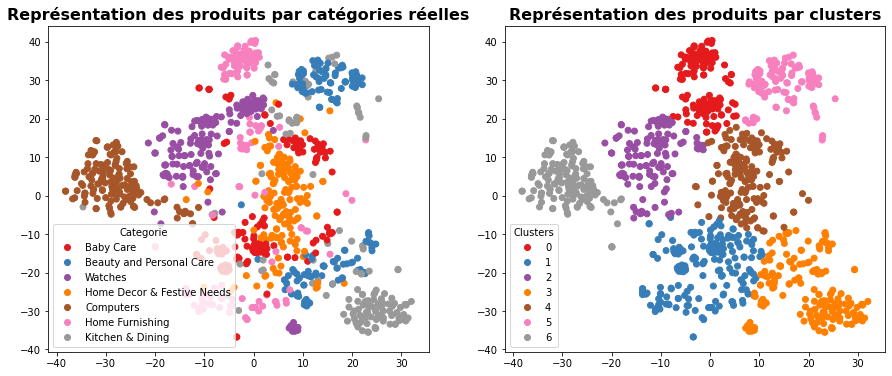

ARI :  0.4065


In [154]:
TSNE_visu_fct(X_tsne_bert, y_cat_num, labels_bert, ARI_bert)

In [155]:
df_bert_pdesc_recap = {'Modèle':['Bert_HF'],
                       'Preprocessing':['No Lemmatization'],
                       '.fit':['pname_desc_clean_bert_use'],
                       '.transform':['pname_desc_clean_bert_use'],
                       'ARI':[ARI_bert], 
                       "Temps d'entrainement": [time_bert],}
df_bert_pdesc_recap = pd.DataFrame(data = df_bert_pdesc_recap)

In [156]:
df_models = pd.concat([df_models, df_bert_pdesc_recap]).reset_index(drop = True)
df_models

,Modèle,Preprocessing,.fit,.transform,ARI,Temps d'entrainement
0,Countvectorizer,Lemmatization,desc_clean_lem,pname_desc_clean_lem,0.2846,26.0
1,Countvectorizer,Lemmatization,pname_clean_lem,pname_desc_clean_lem,0.2114,36.0
2,Countvectorizer,Lemmatization,pname_desc_clean_lem,pname_desc_clean_lem,0.2666,22.0
3,Countvectorizer,No Lemmatization,pname_desc_clean,pname_desc_clean,0.2771,32.0
4,Tf-idf,Lemmatization,pname_desc_clean_lem,pname_desc_clean_lem,0.2665,25.0
5,Tf-idf,No Lemmatization,pname_desc_clean,pname_desc_clean,0.3061,24.0
6,Word2Vec,Lemmatization,pname_desc_clean_lem,pname_desc_clean_lem,0.4189,14.0
7,Word2Vec,No Lemmatization,pname_desc_clean,pname_desc_clean,0.3389,14.0
8,Word2Vec size=600,Lemmatization,pname_desc_clean_lem,pname_desc_clean_lem,0.3812,24.0
9,Bert_HF,No Lemmatization,pname_desc_clean_bert_use,pname_desc_clean_bert_use,0.4065,25.0


faire 2 tableaux: BOW (pas semantique)
à partir de w2v méthode de wordembedding (semantique)

### BERT hub Tensorflow <a class="anchor" id="bert_tensor"></a>

déjà optimisé et pre entrainé donc pas besoin d'optimisation

comprendre sémantique donc mieux vaut tout garder
transformers: poids d'importance mot

In [158]:
# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [159]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer
sentences_list = data_bow['pname_desc_clean_bert_use'].to_list()

In [160]:
# Création des features
features_bert_TF, last_hidden_states_tot_TF = feature_BERT_fct(model, model_type, sentences_list, 
                                                               max_length, batch_size, mode='TFhub')

loading configuration file config.json from cache at C:\Users\milie/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at C:\Users\milie/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\vocab.t

temps traitement :  233.0


In [161]:
ARI_bert_TF, X_tsne_bert_TF, labels_bert_TF, time_bert_TF = ARI_CBOW(features_bert_TF)

C:\Users\milie\anaconda3\envs\projet6\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\milie\anaconda3\envs\projet6\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


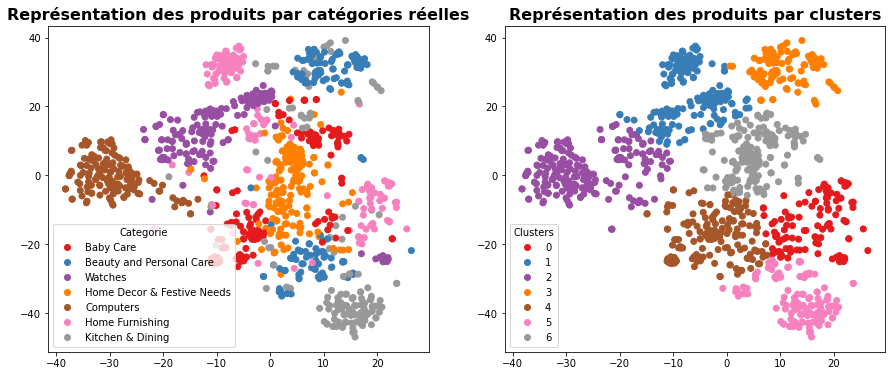

ARI :  0.3634


In [162]:
TSNE_visu_fct(X_tsne_bert_TF, y_cat_num, labels_bert_TF, ARI_bert_TF)

In [163]:
df_bert_TF_pdesc_recap = {'Modèle':['Bert_TF'],
                          'Preprocessing':['No Lemmatization'],
                          '.fit':['pname_desc_clean_bert_use'],
                          '.transform':['pname_desc_clean_bert_use'],
                          'ARI':[ARI_bert_TF], 
                          "Temps d'entrainement": [time_bert_TF],}
df_bert_TF_pdesc_recap = pd.DataFrame(data = df_bert_TF_pdesc_recap)

In [164]:
df_models = pd.concat([df_models, df_bert_TF_pdesc_recap]).reset_index(drop = True)
df_models

,Modèle,Preprocessing,.fit,.transform,ARI,Temps d'entrainement
0,Countvectorizer,Lemmatization,desc_clean_lem,pname_desc_clean_lem,0.2846,26.0
1,Countvectorizer,Lemmatization,pname_clean_lem,pname_desc_clean_lem,0.2114,36.0
2,Countvectorizer,Lemmatization,pname_desc_clean_lem,pname_desc_clean_lem,0.2666,22.0
3,Countvectorizer,No Lemmatization,pname_desc_clean,pname_desc_clean,0.2771,32.0
4,Tf-idf,Lemmatization,pname_desc_clean_lem,pname_desc_clean_lem,0.2665,25.0
5,Tf-idf,No Lemmatization,pname_desc_clean,pname_desc_clean,0.3061,24.0
6,Word2Vec,Lemmatization,pname_desc_clean_lem,pname_desc_clean_lem,0.4189,14.0
7,Word2Vec,No Lemmatization,pname_desc_clean,pname_desc_clean,0.3389,14.0
8,Word2Vec size=600,Lemmatization,pname_desc_clean_lem,pname_desc_clean_lem,0.3812,24.0
9,Bert_HF,No Lemmatization,pname_desc_clean_bert_use,pname_desc_clean_bert_use,0.4065,25.0


### Approches de type word/sentence embedding avec USE <a class="anchor" id="use"></a>

In [165]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [166]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [167]:
batch_size = 10
sentences_list = data_bow['pname_desc_clean_bert_use'].to_list()

In [168]:
features_USE = feature_USE_fct(sentences_list, batch_size)

In [171]:
ARI_use, X_tsne_use, labels_use, time_use = ARI_CBOW(features_USE)

C:\Users\milie\anaconda3\envs\projet6\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\milie\anaconda3\envs\projet6\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


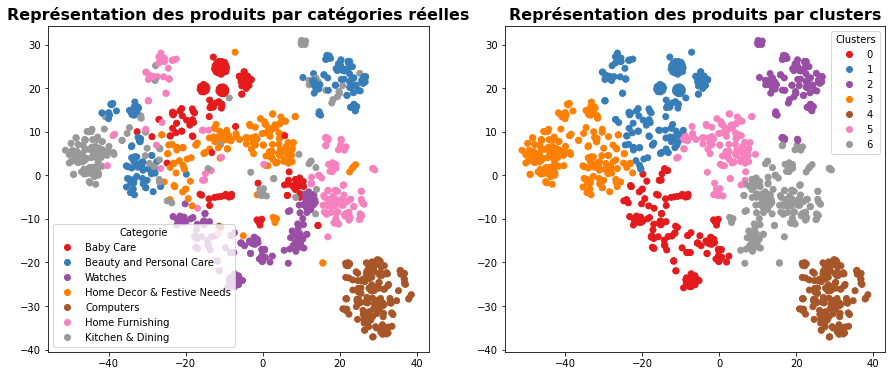

ARI :  0.4532


In [173]:
TSNE_visu_fct(X_tsne_use, y_cat_num, labels_use, ARI_use)

In [174]:
df_use_pdesc_recap = {'Modèle':['USE'],
                      'Preprocessing':['No Lemmatization'],
                      '.fit':['pname_desc_clean_bert_use'],
                      '.transform':['pname_desc_clean_bert_use'],
                      'ARI':[ARI_use], 
                      "Temps d'entrainement": [time_use],}
df_use_pdesc_recap = pd.DataFrame(data = df_use_pdesc_recap)

In [175]:
df_models = pd.concat([df_models, df_use_pdesc_recap]).reset_index(drop = True)
df_models

,Modèle,Preprocessing,.fit,.transform,ARI,Temps d'entrainement
0,Countvectorizer,Lemmatization,desc_clean_lem,pname_desc_clean_lem,0.2846,26.0
1,Countvectorizer,Lemmatization,pname_clean_lem,pname_desc_clean_lem,0.2114,36.0
2,Countvectorizer,Lemmatization,pname_desc_clean_lem,pname_desc_clean_lem,0.2666,22.0
3,Countvectorizer,No Lemmatization,pname_desc_clean,pname_desc_clean,0.2771,32.0
4,Tf-idf,Lemmatization,pname_desc_clean_lem,pname_desc_clean_lem,0.2665,25.0
5,Tf-idf,No Lemmatization,pname_desc_clean,pname_desc_clean,0.3061,24.0
6,Word2Vec,Lemmatization,pname_desc_clean_lem,pname_desc_clean_lem,0.4189,14.0
7,Word2Vec,No Lemmatization,pname_desc_clean,pname_desc_clean,0.3389,14.0
8,Word2Vec size=600,Lemmatization,pname_desc_clean_lem,pname_desc_clean_lem,0.3812,24.0
9,Bert_HF,No Lemmatization,pname_desc_clean_bert_use,pname_desc_clean_bert_use,0.4065,25.0


cnn: Pre-Trained Model as Feature Extractor Preprocessor
https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/manifold


sift sur sklearn
https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_sift.html
descriptor_extractor = SIFT()

descriptor_extractor.detect_and_extract(img1)
keypoints1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors

<div class="alert alert-block alert-info">
    <p>A AMELIORER</p>
    <p>Automatiser df des models</p>
    <p>Raccourcir nom des variables</p>
    <p>Refaire tourner W2v, Bert, Use pour bien comprendre la fonction</p>
    <p>Fonction ARI à améliorer (une avec pca et pas les autres)</p>
</div>

<div class="alert alert-block alert-warning">
    <p> </p>
</div>